# **Setup, imports, dataset load, and split**

**`Purpose`**

This block prepares the environment and dataset so all later experiments are reproducible and fast to run. It first ensures required Python packages are available (PyTorch, Transformers, Datasets, Accelerate, Optuna, scikit-learn, pandas, numpy, matplotlib, openpyxl). It then loads your FiReCS dataset (expects review for text and label for the class), normalizes column names to lowercase, removes incomplete rows, enforces integer labels, and assigns each row a stable id. Finally, it performs a stratified train/validation split to preserve class balance between splits and writes the split IDs to disk so every subsequent run evaluates on the same examples. This guarantees your automated search (Grid vs Random) compares configurations on a fixed and fair validation set.

The block also prints class-proportion checks for both splits. This is a quick sanity step to verify stratification worked (the class distribution in train and validation should be similar). By saving train_ids.csv and val_ids.csv, the notebook downstream can reload the exact splits even if the full dataset is reloaded or preprocessed again—keeping your F2 and F3 experiments consistent. members.

**`Input`**

- A CSV (e.g., `FiReCS.csv`) in the working directory with columns:
  - `review` — the text
  - `label` — class encoded as 0/1/2  
- Permission to install any missing Python packages (the cell will only install if imports fail).

**`Output`**

- Imported libraries ready for use.
- In-memory DataFrames:
  - `df` → cleaned full dataset (integer `label`, added `id`)
  - `train_df`, `val_df` → stratified 80/20 split
- Printed normalized class distributions for train/val.
- Reproducibility files:
  - `train_ids.csv` (column: `id`)
  - `val_ids.csv` (column: `id`)


**`Line-by-line Description.`**
- **Package bootstrap**
  - `import subprocess, sys` — utilities to call `pip` if a package is missing.
  - `packages_map = [("torch","torch"), ..., ("openpyxl","openpyxl")]` — maps pip names to import names.
  - Loop: try `__import__(import_name)`; on `ImportError`, run `pip install -q <package>` and warn if install fails.

- **Core imports**
  - `import os, numpy as np, pandas as pd, torch, json, inspect, optuna; from pathlib import Path` — general utilities, arrays, DataFrames, GPU support, JSON/reflection helpers, and Optuna for tuning.
  - `from sklearn.model_selection import train_test_split` — stratified splitting utility.

- **Load and normalize the dataset**
  - `df = pd.read_csv("FiReCS.csv")` — reads the dataset.
  - `df = df.rename(columns={c: c.lower() for c in df.columns})` — lowercases column names to standardize on `review` and `label`.
  - `assert {'review','label'} <= set(df.columns)` — hard check for expected schema.
  - `df = df.dropna(subset=['review','label']).copy()` — removes rows with missing text/label; `copy()` avoids chained assignment issues.
  - `df['label'] = df['label'].astype(int)` — ensures labels are 0/1/2 integers.
  - `df['id'] = np.arange(len(df))` — adds a unique, stable row identifier for reproducible splits.

- **Stratified train/validation split**
  - `train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])` — creates an 80/20 split with fixed randomness and preserved class proportions.
  - `print(train_df['label'].value_counts(normalize=True).sort_index())` — shows training class ratios.
  - `print(val_df['label'].value_counts(normalize=True).sort_index())` — shows validation class ratios.

- **Persist split IDs for reproducibility**
  - `train_df[['id']].to_csv('train_ids.csv', index=False)` — saves training IDs.
  - `val_df[['id']].to_csv('val_ids.csv', index=False)` — saves validation IDs.

In [ ]:
# Install required packages
import subprocess
import sys

# Package mapping: (pip_name, import_name)
packages_map = [
    ("torch", "torch"),
    ("transformers", "transformers"),
    ("datasets", "datasets"),
    ("accelerate", "accelerate"),
    ("optuna", "optuna"),
    ("scikit-learn", "sklearn"),
    ("pandas", "pandas"),
    ("numpy", "numpy"),
    ("matplotlib", "matplotlib"),
    ("openpyxl", "openpyxl"),
    ("optuna", "optuna"),
]

for pip_name, import_name in packages_map:
    try:
        __import__(import_name)
        print(f"✓ {pip_name} already installed")
    except ImportError:
        print(f"Installing {pip_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name],
                                stdout=subprocess.DEVNULL, stderr=subprocess.PIPE)
            print(f"✓ {pip_name} installed successfully")
        except subprocess.CalledProcessError as e:
            print(f"⚠ Warning: Could not install {pip_name}. You may need to install it manually.")

import os, numpy as np, pandas as pd, torch, json, inspect, optuna
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import optuna

# Optional Colab support
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    files = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if not os.path.exists("FiReCS.csv"):
    if IN_COLAB and files is not None:
        uploaded = files.upload()
    else:
        raise FileNotFoundError("FiReCS.csv not found. Please ensure the file is in the current directory.")
df = pd.read_csv("FiReCS.csv")

df = df.rename(columns={c:c.lower() for c in df.columns})
assert {'review','label'} <= set(df.columns), "CSV must have 'review' and 'label' columns."

df = df.dropna(subset=['review','label']).copy()
df['label'] = df['label'].astype(int)
df['id'] = np.arange(len(df))

train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)
print(train_df['label'].value_counts(normalize=True).sort_index())
print(val_df['label'].value_counts(normalize=True).sort_index())

train_df[['id']].to_csv('train_ids.csv', index=False)
val_df[['id']].to_csv('val_ids.csv', index=False)


✓ torch already installed
✓ transformers already installed
✓ datasets already installed
✓ accelerate already installed
✓ optuna already installed
✓ scikit-learn already installed
✓ pandas already installed
✓ numpy already installed
✓ matplotlib already installed
✓ openpyxl already installed
✓ optuna already installed
Using device: cuda
label
0    0.324421
1    0.347241
2    0.328338
Name: proportion, dtype: float64
label
0    0.324251
1    0.347411
2    0.328338
Name: proportion, dtype: float64


# Data cleaning and 80/10/10 split (reproducible)



#### Purpose / Description
This cell cleans the raw text, adds a simple **code-switch ratio** feature for exploratory analysis, and creates a **reproducible** 80/10/10 train–validation–test split. Cleaning removes HTML tags/entities, control characters, extra whitespace, and compresses long letter repeats (e.g., “goooood” → “goood”). It also drops empty texts and exact (text,label) duplicates to avoid leakage. For splits, it writes/loads `train_ids.csv`, `val_ids.csv`, and `test_ids.csv` so every run evaluates the same examples.

#### Input
- In-memory `df` from an earlier cell with columns: `review`, `label`, and `id`.
- Libraries already imported earlier: `os`, `pandas as pd`, `numpy as np`.

#### Output
- Updated `df` with cleaned `review` and new `cs_ratio` column.
- In-memory splits: `df_train`, `df_val`, `df_test`.
- Reproducibility files (created if missing): `train_ids.csv`, `val_ids.csv`, `test_ids.csv`.
- Printed diagnostics: kept rows after cleaning, split sizes, and label ratios per split.

---

#### Line-by-Line Explanation

`import re, html`  
Imports the regular-expression module and HTML utilities (for unescaping entities like `&amp;`).

`from collections import Counter`  
Brings in a counting helper (available for tallies; not strictly required later).

`from sklearn.model_selection import train_test_split`  
Imports the function used to make stratified splits of the dataset.

`# --- Cleaning helpers ---`  
Section comment to mark the start of text-cleaning utilities.

`CTRL_RE = re.compile(r"[\x00-\x08\x0B\x0C\x0E-\x1F]")`  
Precompiles a regex that matches non-printable control characters to remove from text.

`REPEAT_RE = re.compile(r"(\w)\1{2,}")`  
Precompiles a regex that detects any word character repeated 3+ times (e.g., “heyyy”).

`def strip_html(text: str) -> str:`  
Begins a helper that strips HTML and unescapes entities from a single text string.

`    if not isinstance(text, str):`  
Checks the input type to guard against non-string values.

`        return ""`  
Returns an empty string when the input is not a string.

`    # unescape HTML entities then drop tags`  
Comment describing the two-step HTML cleanup.

`    t = html.unescape(text)`  
Converts HTML entities to their characters (e.g., `&lt;` → `<`).

`    t = re.sub(r"<[^>]+>", " ", t)`  
Removes any HTML tags by replacing them with a space.

`    return t`  
Returns the cleaned string.

`def squash_repeats(text: str) -> str:`  
Starts a helper that compresses excessive character repetitions.

`    return REPEAT_RE.sub(r"\1\1", text)`  
Replaces any 3+ repeats of a character with exactly 2 (keeps tone but reduces noise).

`def basic_clean(text: str) -> str:`  
Defines a higher-level cleaner that chains multiple cleaning steps.

`    t = str(text)`  
Casts the input to string to avoid errors with non-string inputs.

`    t = strip_html(t)`  
Applies HTML unescape and tag removal.

`    t = CTRL_RE.sub(" ", t)`  
Removes control characters by replacing them with a space.

`    t = re.sub(r"\s+", " ", t).strip()`  
Collapses runs of whitespace to a single space and trims leading/trailing spaces.

`    t = squash_repeats(t)`  
Compresses long character repeats (e.g., “noooo” → “noo”).

`    return t`  
Outputs the fully cleaned text.

`# Apply cleaning to the loaded df (from earlier cell)`  
Comment indicating the cleaning is now applied to the dataset.

`df = df.copy()`  
Copies the DataFrame to avoid mutating the original reference.

`df['review'] = df['review'].astype(str).map(basic_clean)`  
Converts all reviews to strings and applies the `basic_clean` function to each one.

`# drop empties and exact duplicates`  
Comment describing the next pruning steps.

`before = len(df)`  
Stores the row count before pruning for reporting.

`df = df[(df['review'].str.len() > 0)].drop_duplicates(subset=['review','label']).reset_index(drop=True)`  
Drops rows with empty `review`, then removes exact duplicates based on (`review`,`label`), and resets the index.

`after = len(df)`  
Stores the row count after pruning.

`print(f"Cleaned dataset: kept {after}/{before} rows")`  
Logs how many rows remained after cleaning and deduplication.

`# Optional: simple code-switch ratio (EDA only)`  
Comment introducing a lightweight Taglish code-switching heuristic for exploration.

`EN_RE = re.compile(r"[A-Za-z]{3,}")`  
Regex that matches English-like tokens (alphabetic sequences with length ≥ 3).

`TL_HINTS = set(["po","opo","naman","kuya","ate","nga","na","lang","din","rin","daw","ba","yung","yung","ang","sa","si","ni","kay","sana","wala","meron","sobrang","sobrang","ganda","pang","bilis","salamat"])  # lightweight hints`  
Defines a small set of common Tagalog hint words to approximate Tagalog presence.

`def code_switch_ratio(text: str) -> float:`  
Begins a helper that estimates English–Tagalog mix in a string.

`    tokens = re.findall(r"\w+", text.lower())`  
Tokenizes the text into alphanumeric word tokens in lowercase.

`    if not tokens:`  
Checks for empty token lists.

`        return 0.0`  
Returns 0 if no tokens were found.

`    en_like = sum(1 for tok in tokens if EN_RE.fullmatch(tok) is not None)`  
Counts tokens that fully match the English-like regex.

`    tl_like = sum(1 for tok in tokens if tok in TL_HINTS)`  
Counts tokens that belong to the Tagalog hint set.

`    return en_like / max(1, (en_like + tl_like))`  
Returns the English proportion over the sum (guarding against division by zero).

`df['cs_ratio'] = df['review'].map(code_switch_ratio)`  
Creates a new EDA column with the code-switch ratio for each review.

`# --- Reproducible 80/10/10 split ---`  
Section comment to mark the start of the split logic.

`RANDOM_SEED = 42`  
Sets a fixed seed for reproducible splitting.

`if not {'train_ids.csv','val_ids.csv','test_ids.csv'} <= set(os.listdir('.')):`  
Checks if any of the three ID files are missing in the current directory.

`    # stratified train vs temp (80/20)`  
Comment: first split into 80% train and 20% temp with stratification.

`    df_train, df_temp = train_test_split(`  
Begins the first split call.

`        df, test_size=0.2, random_state=RANDOM_SEED, stratify=df['label']`  
Specifies 80/20 split, fixed seed, and stratification by label.

`    )`  
Closes the first split call.

`    # split temp 50/50 -> 10/10`  
Comment: split the 20% temp set into two equal 10% parts for val and test.

`    df_val, df_test = train_test_split(`  
Begins the second split call.

`        df_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=df_temp['label']`  
Specifies 50/50 split of temp with the same seed and stratification by temp labels.

`    )`  
Closes the second split call.

`    df_train[['id']].to_csv('train_ids.csv', index=False)`  
Saves the training IDs for reproducibility.

`    df_val[['id']].to_csv('val_ids.csv', index=False)`  
Saves the validation IDs.

`    df_test[['id']].to_csv('test_ids.csv', index=False)`  
Saves the test IDs.

`else:`  
If all three ID files already exist, reuse them to reconstruct the exact same splits.

`    ids_tr = set(pd.read_csv('train_ids.csv')['id'].tolist())`  
Loads the training ID set from disk.

`    ids_va = set(pd.read_csv('val_ids.csv')['id'].tolist())`  
Loads the validation ID set from disk.

`    ids_te = set(pd.read_csv('test_ids.csv')['id'].tolist())`  
Loads the test ID set from disk.

`    df_train = df[df['id'].isin(ids_tr)].copy()`  
Rebuilds the training DataFrame by filtering on the saved IDs.

`    df_val   = df[df['id'].isin(ids_va)].copy()`  
Rebuilds the validation DataFrame by filtering on the saved IDs.

`    df_test  = df[df['id'].isin(ids_te)].copy()`  
Rebuilds the test DataFrame by filtering on the saved IDs.

`print({`  
Starts printing a small dictionary summarizing split sizes.

`    'train': len(df_train), 'val': len(df_val), 'test': len(df_test)`  
Computes the sizes of each split.

`})`  
Closes the dict printout.

`print('Label ratios (train):', df_train['label'].value_counts(normalize=True).sort_index().to_dict())`  
Prints the normalized label distribution for the training set.

`print('Label ratios (val):  ', df_val['label'].value_counts(normalize=True).sort_index().to_dict())`  
Prints the normalized label distribution for the validation set.

`print('Label ratios (test): ', df_test['label'].value_counts(normalize=True).sort_index().to_dict())`  
Prints the normalized label distribution for the test set.

In [ ]:
import re, html
from collections import Counter
from sklearn.model_selection import train_test_split

# --- Cleaning helpers ---
CTRL_RE = re.compile(r"[\x00-\x08\x0B\x0C\x0E-\x1F]")
REPEAT_RE = re.compile(r"(\w)\1{2,}")

def strip_html(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # unescape HTML entities then drop tags
    t = html.unescape(text)
    t = re.sub(r"<[^>]+>", " ", t)
    return t

def squash_repeats(text: str) -> str:
    return REPEAT_RE.sub(r"\1\1", text)

def basic_clean(text: str) -> str:
    t = str(text)
    t = strip_html(t)
    t = CTRL_RE.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()
    t = squash_repeats(t)
    return t

# Apply cleaning to the loaded df (from earlier cell)
df = df.copy()
df['review'] = df['review'].astype(str).map(basic_clean)
# drop empties and exact duplicates
before = len(df)
df = df[(df['review'].str.len() > 0)].drop_duplicates(subset=['review','label']).reset_index(drop=True)
after = len(df)
print(f"Cleaned dataset: kept {after}/{before} rows")

# Optional: simple code-switch ratio (EDA only)
EN_RE = re.compile(r"[A-Za-z]{3,}")
TL_HINTS = set(["po","opo","naman","kuya","ate","nga","na","lang","din","rin","daw","ba","yung","yung","ang","sa","si","ni","kay","sana","wala","meron","sobrang","sobrang","ganda","pang","bilis","salamat"])  # lightweight hints

def code_switch_ratio(text: str) -> float:
    tokens = re.findall(r"\w+", text.lower())
    if not tokens:
        return 0.0
    en_like = sum(1 for tok in tokens if EN_RE.fullmatch(tok) is not None)
    tl_like = sum(1 for tok in tokens if tok in TL_HINTS)
    return en_like / max(1, (en_like + tl_like))

df['cs_ratio'] = df['review'].map(code_switch_ratio)

# --- Reproducible 80/10/10 split ---
RANDOM_SEED = 42
if not {'train_ids.csv','val_ids.csv','test_ids.csv'} <= set(os.listdir('.')):
    # stratified train vs temp (80/20)
    df_train, df_temp = train_test_split(
        df, test_size=0.2, random_state=RANDOM_SEED, stratify=df['label']
    )
    # split temp 50/50 -> 10/10
    df_val, df_test = train_test_split(
        df_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=df_temp['label']
    )
    df_train[['id']].to_csv('train_ids.csv', index=False)
    df_val[['id']].to_csv('val_ids.csv', index=False)
    df_test[['id']].to_csv('test_ids.csv', index=False)
else:
    ids_tr = set(pd.read_csv('train_ids.csv')['id'].tolist())
    ids_va = set(pd.read_csv('val_ids.csv')['id'].tolist())
    ids_te = set(pd.read_csv('test_ids.csv')['id'].tolist())
    df_train = df[df['id'].isin(ids_tr)].copy()
    df_val   = df[df['id'].isin(ids_va)].copy()
    df_test  = df[df['id'].isin(ids_te)].copy()

print({
    'train': len(df_train), 'val': len(df_val), 'test': len(df_test)
})
print('Label ratios (train):', df_train['label'].value_counts(normalize=True).sort_index().to_dict())
print('Label ratios (val):  ', df_val['label'].value_counts(normalize=True).sort_index().to_dict())
print('Label ratios (test): ', df_test['label'].value_counts(normalize=True).sort_index().to_dict())


Cleaned dataset: kept 7338/7340 rows
{'train': 5870, 'val': 1468, 'test': 734}
Label ratios (train): {0: 0.32453151618398635, 1: 0.3471890971039182, 2: 0.3282793867120954}
Label ratios (val):   {0: 0.3242506811989101, 1: 0.3474114441416894, 2: 0.32833787465940056}
Label ratios (test):  {0: 0.3242506811989101, 1: 0.3474114441416894, 2: 0.32833787465940056}


# Fast mode toggle (optional)

Set `FAST_MODE` to `True` to downsample the training split (40%) for quicker CPU experiments. Leave it `False` for full-run results.


In [ ]:
FAST_MODE = True  # Set False for full runs
TRAIN_FRACTION = 0.80 if FAST_MODE else 1.0
VAL_FRACTION = 1.0  # Keep full validation/test by default

if FAST_MODE and TRAIN_FRACTION < 1.0:
    df_train = (df_train
                .sample(frac=TRAIN_FRACTION, random_state=RANDOM_SEED)
                .sort_values('id')
                .reset_index(drop=True))
    if VAL_FRACTION < 1.0:
        df_val = (df_val
                  .sample(frac=VAL_FRACTION, random_state=RANDOM_SEED)
                  .sort_values('id')
                  .reset_index(drop=True))
        df_test = (df_test
                   .sample(frac=VAL_FRACTION, random_state=RANDOM_SEED)
                   .sort_values('id')
                   .reset_index(drop=True))
    print(f"[FAST_MODE] train={len(df_train)} (~{TRAIN_FRACTION*100:.0f}%), val={len(df_val)}, test={len(df_test)})")
else:
    print("FAST_MODE disabled: using full train/val/test splits")


[FAST_MODE] train=4696 (~80%), val=1468, test=734)


# Automated hyperparameter tuning configuration

Toggle these settings to enable or customise the grid and random search experiments that will be executed later in the notebook.


In [ ]:
AUTO_TUNE_ENABLED = True  # Set to False to skip automated searches

GRID_SEARCH_SPACE = {
    "learning_rate": [5e-5, 3e-5, 2e-5],
    "per_device_train_batch_size": [8, 16],
    "weight_decay": [0.0, 0.05],
    "num_train_epochs": [2, 3],
}

RANDOM_SEARCH_SPACE = {
    # (mode, low, high, log_scale?) definitions, interpreted later
    "learning_rate": ("log_uniform", 2e-5, 5e-5),
    "per_device_train_batch_size": ("choice", [8, 12, 16, 24]),
    "weight_decay": ("uniform", 0.0, 0.1),
    "num_train_epochs": ("int", 2, 4),
}

RANDOM_TRIALS = 8  # adjust for more extensive exploration


# **Baseline TF-IDF + Logistic Regression and log row**

#### Purpose / Description
This cell trains a fast **TF–IDF + Logistic Regression** baseline, evaluates it on the **validation** split, prints macro-F1 and accuracy, and appends a compact row to `runs_log.csv` so this baseline appears alongside later transformer runs and automated searches. It vectorizes text using 1–2-gram TF–IDF features (capped vocabulary), fits Logistic Regression with a generous iteration limit for convergence, and records a reproducible log row with key fields (metrics, seed, and a short note).

#### Input
- In-memory splits: `train_df` and `val_df` with columns `review` (text) and `label` (0/1/2).
- `accuracy_score`, `f1_score` imported earlier (from `sklearn.metrics`), plus `pandas as pd` and `os`.

#### Output
- Printed dict with validation **accuracy** and **macro-F1** for this baseline.
- Appended row in `runs_log.csv` describing this run (header auto-created if file doesn’t exist).

---

#### Line-by-Line Explanation

`from sklearn.feature_extraction.text import TfidfVectorizer`  
Imports the TF–IDF transformer to convert raw text into sparse n-gram features.

`from sklearn.linear_model import LogisticRegression`  
Imports the Logistic Regression classifier.

`tfidf = TfidfVectorizer(`  
Starts constructing the TF–IDF vectorizer object.

`    max_features=50000,`  
Caps the vocabulary at 50,000 features to keep runtime and memory reasonable.

`    ngram_range=(1,2),`  
Uses unigrams and bigrams to capture short phrases (better than unigrams alone).

`    lowercase=True`  
Normalizes case so “Good” and “good” map to the same feature.

`X_tr = tfidf.fit_transform(train_df['review'])`  
Learns the TF–IDF vocabulary/statistics **on training text only** and produces the sparse training matrix.

`y_tr = train_df['label'].values`  
Extracts the training labels as a NumPy array.

`X_va = tfidf.transform(val_df['review'])`  
Applies the **already-fit** vectorizer to the validation text (no leakage of val text into fitting).

`y_va = val_df['label'].values`  
Extracts the validation labels as a NumPy array.

`logreg = LogisticRegression(max_iter=2000, n_jobs=None, class_weight=None)`  
Configures Logistic Regression: up to 2000 iterations (to ensure convergence), default core usage, and no explicit class weighting.

`logreg.fit(X_tr, y_tr)`  
Fits the classifier on the TF–IDF training features and labels.

`preds = logreg.predict(X_va)`  
Generates predicted labels for the validation split.

`acc_base = accuracy_score(y_va, preds)`  
Computes **validation accuracy**.

`f1_base  = f1_score(y_va, preds, average='macro')`  
Computes **validation macro-F1** (each class contributes equally).

`print({"model":"tfidf-logreg", "accuracy":acc_base, "f1_macro":f1_base})`  
Prints a concise dictionary of the baseline metrics for quick inspection.

`row = {`  
Begins building a log entry compatible with the project’s experiment log schema.

`    "member":"baseline", "model":"tfidf-logreg",`  
Tags this run as a baseline and names the model.

`    "num_train_epochs":None, "per_device_train_batch_size":None,`  
Fills transformer-specific fields with `None` (not applicable to this baseline).

`    "learning_rate":None, "weight_decay":None, "warmup_steps":None,`  
More transformer-only fields set to `None`.

`    "lr_scheduler_type":None, "gradient_accumulation_steps":None,`  
Additional transformer fields set to `None`.

`    "max_seq_length":None, "seed":42, "fp16":False,`  
Records a seed for reproducibility; marks fp16 as False (not used here).

`    "accuracy":acc_base, "f1_macro":f1_base, "notes":"TF-IDF + LogReg baseline"`  
Stores the key validation metrics and a short note.


`pd.DataFrame([row]).to_csv("runs_log.csv", mode="a",`  
Creates a one-row DataFrame and opens the log file in **append** mode.

`                           index=False, header=not os.path.exists("runs_log.csv"))`  
Writes without index; includes a header **only** if the file doesn’t exist yet (keeps a single header line across runs).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    lowercase=True
)
X_tr = tfidf.fit_transform(train_df['review'])
y_tr = train_df['label'].values
X_va = tfidf.transform(val_df['review'])
y_va = val_df['label'].values

logreg = LogisticRegression(max_iter=2000, n_jobs=None, class_weight=None)
logreg.fit(X_tr, y_tr)

preds = logreg.predict(X_va)
acc_base = accuracy_score(y_va, preds)
f1_base  = f1_score(y_va, preds, average='macro')
print({"model":"tfidf-logreg", "accuracy":acc_base, "f1_macro":f1_base})

row = {
    "member":"baseline", "model":"tfidf-logreg",
    "num_train_epochs":None, "per_device_train_batch_size":None,
    "learning_rate":None, "weight_decay":None, "warmup_steps":None,
    "lr_scheduler_type":None, "gradient_accumulation_steps":None,
    "max_seq_length":None, "seed":42, "fp16":False,
    "accuracy":acc_base, "f1_macro":f1_base, "notes":"TF-IDF + LogReg baseline"
}
pd.DataFrame([row]).to_csv("runs_log.csv", mode="a",
                           index=False, header=not os.path.exists("runs_log.csv"))


{'model': 'tfidf-logreg', 'accuracy': 0.8024523160762943, 'f1_macro': 0.8050088305616837}


# **Baseline ablations (TF‑IDF + Logistic Regression)**


#### Purpose / Description
This cell runs a **classical baseline search** using scikit-learn: it builds TF–IDF + Logistic Regression pipelines, performs a **5-fold Stratified** grid search over key classifier hyperparameters (`C`, `class_weight`), **compares two TF–IDF variants** (word 1–2 grams vs character-wb 3–5 grams), picks the best by cross-validated **macro-F1**, validates on the held-out **val** split, then **refits** on **train + val** and evaluates on **test**. It saves per-example test predictions and a confusion matrix image, and appends a structured row to `runs_log.csv` so these baseline results sit alongside transformer runs.

#### Input
- Clean, split dataframes: `df_train`, `df_val`, `df_test` with `review` and `label`.
- Globals: `RANDOM_SEED` defined earlier.
- Installed scikit-learn, matplotlib, numpy, pandas.

#### Output
- Console prints: best CV scores/params per variant; validation metrics; final test metrics.
- Files:
  - `baseline_predictions_test.csv` — per-example test predictions.
  - `baseline_cm_test.png` — saved confusion matrix (test).
  - `runs_log.csv` — appended row describing the run.

---

#### Line-by-Line Explanation

`import numpy as np, matplotlib.pyplot as plt`  
Imports NumPy for arrays/concatenation and Matplotlib for plotting the confusion matrix.

`from sklearn.model_selection import StratifiedKFold, GridSearchCV`  
Brings in stratified K-fold splitter and grid search for hyperparameter tuning.

`from sklearn.pipeline import Pipeline`  
Allows chaining vectorizer and classifier into a single estimator.

`from sklearn.feature_extraction.text import TfidfVectorizer`  
TF–IDF transformer for word/character n-gram features.

`from sklearn.linear_model import LogisticRegression`  
Linear classifier used in the baselines.

`from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score`  
Evaluation utilities (macro-F1/accuracy) and tools to build/plot a confusion matrix.

`X_tr = df_train['review'].tolist(); y_tr = df_train['label'].values`  
Extracts training texts as a Python list and labels as a NumPy array.

`X_va = df_val['review'].tolist();   y_va = df_val['label'].values`  
Extracts validation texts/labels for later sanity-checking the picked model.

`X_te = df_test['review'].tolist();  y_te = df_test['label'].values`  
Extracts test texts/labels for final reporting after refit.

`skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)`  
Defines a **5-fold stratified** splitter with shuffling and fixed seed for reproducibility.

`param_grid = {`  
Starts the hyperparameter grid for Logistic Regression inside the pipeline.

`    'clf__C': [0.5, 1.0, 2.0, 4.0],`  
Regularization strength values to try (pipeline step name `clf`, param `C`).

`    'clf__class_weight': [None, 'balanced']`  
Either no weighting or automatic class weighting to combat imbalance.

`variants = {`  
Begins a dictionary of TF–IDF variants to compare.

`    'word_1_2': TfidfVectorizer(max_features=50000, ngram_range=(1,2), lowercase=True),`  
Variant A: word-level 1–2 grams, 50k vocab cap, lowercase normalization.

`    'charwb_3_5': TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), max_features=100000, lowercase=True)`  
Variant B: character n-grams within word boundaries (3–5), up to 100k features.


`best = None`  
Holds the best-performing variant after grid search (to be replaced once found).

`for name, vec in variants.items():`  
Iterates over each TF–IDF variant to run its own grid search.

`    pipe = Pipeline([`  
Starts a pipeline: vectorizer → classifier.

`        ('vec', vec),`  
Pipeline step `vec`: the current TF–IDF variant.

`        ('clf', LogisticRegression(max_iter=2000))`  
Pipeline step `clf`: Logistic Regression with a high iteration cap.

`    ])`  
Closes the pipeline definition.

`    gs = GridSearchCV(`  
Begins the grid search wrapper around the pipeline.

`        pipe, param_grid=param_grid, scoring='f1_macro', cv=skf, n_jobs=-1, verbose=1`  
Uses the pipeline, earlier grid, **macro-F1** as the objective, the 5-fold splitter, all CPU cores, and verbose progress.

`    )`  
Closes the grid search configuration.

`    gs.fit(X_tr, y_tr)`  
Runs cross-validated training across all param combinations for this variant.

`    print(f"Variant {name} best CV f1_macro: {gs.best_score_:.4f} with {gs.best_params_}")`  
Reports the top cross-validated macro-F1 and the corresponding hyperparameters for this variant.

`    if best is None or gs.best_score_ > best['cv']:`  
Checks if this variant beats the current best.

`        best = {`  
Stores details of the new best configuration/estimator.

`            'name': name,`  
The variant key (e.g., `word_1_2` or `charwb_3_5`).

`            'cv': gs.best_score_,`  
Best cross-validated macro-F1 for this variant.

`            'best_params': gs.best_params_,`  
The hyperparameters that achieved the best CV score.

`            'estimator': gs.best_estimator_`  
The pipeline fitted on the full training data under the best params.

`# Validate picked model on val`  
Section comment: evaluate the chosen variant/pipeline on the validation split.

`val_preds = best['estimator'].predict(X_va)`  
Generates predictions on validation texts with the best pipeline.

`val_acc = accuracy_score(y_va, val_preds)`  
Computes validation accuracy to sanity-check generalization.

`val_f1m = f1_score(y_va, val_preds, average='macro')`  
Computes validation macro-F1.

`print({'pick': best['name'], 'val_acc': val_acc, 'val_f1_macro': val_f1m})`  
Logs which variant was picked and its validation metrics.

`# Refit on train+val`  
Section comment: refit the **final** model on combined train and validation data.

`X_trval = X_tr + X_va`  
Concatenates training and validation texts (lists) for refit.

`y_trval = np.concatenate([y_tr, y_va])`  
Concatenates training and validation labels (arrays).

`best_refit = Pipeline([`  
Builds a fresh pipeline for the refit stage.

`    ('vec', variants[best['name']]),`  
Uses the **same** TF–IDF variant that won CV.

`    ('clf', LogisticRegression(max_iter=2000, **{k.split('__')[1]:v for k,v in best['best_params'].items()}))`  
Recreates Logistic Regression with `max_iter=2000` and injects the **best params** (e.g., `C`, `class_weight`) extracted from `best_params` by stripping the `clf__` prefix.

`])`  
Closes the refit pipeline.

`best_refit.fit(X_trval, y_trval)`  
Fits the final model on **train + val** to use all supervised data before testing.

`y_pred = best_refit.predict(X_te)`  
Predicts labels on the **test** split.

`acc = accuracy_score(y_te, y_pred)`  
Computes test accuracy.

`f1m = f1_score(y_te, y_pred, average='macro')`  
Computes test macro-F1.

`print({'baseline_best_test_acc': acc, 'baseline_best_test_f1_macro': f1m, 'variant': best['name']})`  
Prints final test metrics and the winning variant name.

`# Save predictions and confusion matrix`  
Section comment: create artifacts for the report/appendix.

`import pandas as pd, os`  
Imports pandas and os (used for saving files and logging).

`pd.DataFrame({'review': X_te, 'gold': y_te, 'pred': y_pred}).to_csv('baseline_predictions_test.csv', index=False)`  
Saves a CSV of per-example test predictions for error analysis.

`cm = confusion_matrix(y_te, y_pred, labels=[0,1,2])`  
Builds the raw confusion matrix with a fixed label order.

`fig, ax = plt.subplots(figsize=(4,4))`  
Creates a small Matplotlib figure/axes for the plot.

`ConfusionMatrixDisplay(cm, display_labels=['neg','neu','pos']).plot(ax=ax, colorbar=False)`  
Renders the confusion matrix with class labels and without a colorbar (cleaner for reports).

`plt.tight_layout(); plt.savefig('baseline_cm_test.png', dpi=150); plt.close()`  
Tightens layout, saves the figure as PNG (150 dpi), and closes the figure to free memory.

`# Append to log`  
Section comment: add a summary row to the global experiment log.

`row = {`  
Begins a dict describing this baseline search and final test results.

`    'member': 'baseline-grid',`  
Tags the row as a baseline grid-search entry.

`    'model': f'tfidf-{best["name"]}',`  
Records which TF–IDF variant was used.

`    'num_train_epochs': None,`  
Transformer-specific fields (not applicable) are set to `None`.

`    'per_device_train_batch_size': None,`  
N/A for scikit-learn baseline.

`    'learning_rate': None,`  
N/A for scikit-learn baseline.

`    'weight_decay': None,`  
N/A for scikit-learn baseline.

`    'warmup_steps': None,`  
N/A for scikit-learn baseline.

`    'lr_scheduler_type': None,`  
N/A for scikit-learn baseline.

`    'gradient_accumulation_steps': None,`  
N/A for scikit-learn baseline.

`    'max_seq_length': None,`  
N/A for TF–IDF baseline.

`    'seed': RANDOM_SEED,`  
Records the seed used in CV splitting.

`    'fp16': False,`  
Half precision not applicable here.

`    'accuracy': acc,`  
Final **test** accuracy.

`    'f1_macro': f1m,`  
Final **test** macro-F1.

`    'notes': f'GridSearchCV 5-fold; best_params={best["best_params"]}'`  
Free-form note including the best hyperparameters for traceability.

`pd.DataFrame([row]).to_csv('runs_log.csv', mode='a', index=False, header=not os.path.exists('runs_log.csv'))`  
Appends the row to `runs_log.csv`; writes a header only if the file didn’t exist yet to avoid duplicate headers.


In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

X_tr = df_train['review'].tolist(); y_tr = df_train['label'].values
X_va = df_val['review'].tolist();   y_va = df_val['label'].values
X_te = df_test['review'].tolist();  y_te = df_test['label'].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
param_grid = {
    'clf__C': [0.5, 1.0, 2.0, 4.0],
    'clf__class_weight': [None, 'balanced']
}

variants = {
    'word_1_2': TfidfVectorizer(max_features=50000, ngram_range=(1,2), lowercase=True),
    'charwb_3_5': TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), max_features=100000, lowercase=True)
}

best = None
for name, vec in variants.items():
    pipe = Pipeline([
        ('vec', vec),
        ('clf', LogisticRegression(max_iter=2000))
    ])
    gs = GridSearchCV(
        pipe, param_grid=param_grid, scoring='f1_macro', cv=skf, n_jobs=-1, verbose=1
    )
    gs.fit(X_tr, y_tr)
    print(f"Variant {name} best CV f1_macro: {gs.best_score_:.4f} with {gs.best_params_}")
    if best is None or gs.best_score_ > best['cv']:
        best = {
            'name': name,
            'cv': gs.best_score_,
            'best_params': gs.best_params_,
            'estimator': gs.best_estimator_
        }

# Validate picked model on val
val_preds = best['estimator'].predict(X_va)
val_acc = accuracy_score(y_va, val_preds)
val_f1m = f1_score(y_va, val_preds, average='macro')
print({'pick': best['name'], 'val_acc': val_acc, 'val_f1_macro': val_f1m})

# Refit on train+val
X_trval = X_tr + X_va
y_trval = np.concatenate([y_tr, y_va])
best_refit = Pipeline([
    ('vec', variants[best['name']]),
    ('clf', LogisticRegression(max_iter=2000, **{k.split('__')[1]:v for k,v in best['best_params'].items()}))
])
best_refit.fit(X_trval, y_trval)

y_pred = best_refit.predict(X_te)
acc = accuracy_score(y_te, y_pred)
f1m = f1_score(y_te, y_pred, average='macro')
print({'baseline_best_test_acc': acc, 'baseline_best_test_f1_macro': f1m, 'variant': best['name']})

# Save predictions and confusion matrix
import pandas as pd, os
pd.DataFrame({'review': X_te, 'gold': y_te, 'pred': y_pred}).to_csv('baseline_predictions_test.csv', index=False)
cm = confusion_matrix(y_te, y_pred, labels=[0,1,2])
fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay(cm, display_labels=['neg','neu','pos']).plot(ax=ax, colorbar=False)
plt.tight_layout(); plt.savefig('baseline_cm_test.png', dpi=150); plt.close()

# Append to log
row = {
    'member': 'baseline-grid',
    'model': f'tfidf-{best["name"]}',
    'num_train_epochs': None,
    'per_device_train_batch_size': None,
    'learning_rate': None,
    'weight_decay': None,
    'warmup_steps': None,
    'lr_scheduler_type': None,
    'gradient_accumulation_steps': None,
    'max_seq_length': None,
    'seed': RANDOM_SEED,
    'fp16': False,
    'accuracy': acc,
    'f1_macro': f1m,
    'notes': f'GridSearchCV 5-fold; best_params={best["best_params"]}'
}
pd.DataFrame([row]).to_csv('runs_log.csv', mode='a', index=False, header=not os.path.exists('runs_log.csv'))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Variant word_1_2 best CV f1_macro: 0.8010 with {'clf__C': 4.0, 'clf__class_weight': None}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Variant charwb_3_5 best CV f1_macro: 0.8061 with {'clf__C': 1.0, 'clf__class_weight': None}
{'pick': 'charwb_3_5', 'val_acc': 0.8038147138964578, 'val_f1_macro': 0.8064406999307708}
{'baseline_best_test_acc': 0.8937329700272479, 'baseline_best_test_f1_macro': 0.8944810164886371, 'variant': 'charwb_3_5'}


# **Model switcher, tokenization, dataset tensors, and model init**

#### Purpose / Description
This cell detects the available hardware (GPU/CPU) and sets OS-aware performance knobs, selects a pretrained backbone, builds a fast tokenizer, converts pandas splits into Hugging Face `Dataset` objects, **tokenizes with safe parallelism** (Windows vs Linux/Mac), sets PyTorch tensor formatting, and finally initializes the sequence classification model on the correct device. The result is a ready-to-train pipeline that honors platform constraints while keeping tokenization and batching efficient.

#### Input
- Split DataFrames: `df_train`, `df_val`, `df_test` with columns `review` and `label`.
- Libraries already installed/imported earlier: `torch`, `pandas`, `datasets`, `transformers`, `platform`.

#### Output
- Hardware flags: `USE_GPU`, `device`, `NUM_WORKERS`, `PIN_MEMORY`.
- Tokenization objects and datasets: `tokenizer`, `ds_train`, `ds_val`, `ds_test`.
- Model: `model` (`AutoModelForSequenceClassification`) placed on the selected `device`.
- Console prints summarizing GPU info, tokenization strategy, dataset sizes, and model status.

---

#### Line-by-Line Explanation

`from datasets import Dataset`  
Imports HF `Dataset` to convert pandas tables into datasets compatible with tokenization and PyTorch formatting.

`from transformers import AutoTokenizer, AutoModelForSequenceClassification`  
Imports factories for tokenizer and classification model tied to the chosen backbone.

`import platform`  
Allows detecting the operating system (Windows vs Linux/Mac) to adjust multiprocessing safely.

`# GPU detection and optimization settings`  
Comment: start hardware checks and performance flags.

`USE_GPU = torch.cuda.is_available()`  
Checks whether a CUDA-capable GPU is available.

`if USE_GPU:`  
Branches into the GPU path when CUDA is detected.

`    print(f"✓ GPU detected: {torch.cuda.get_device_name(0)}")`  
Prints the GPU model name for visibility.

`    print(f"  CUDA Version: {torch.version.cuda}")`  
Shows the CUDA toolkit version used by PyTorch.

`    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")`  
Displays total GPU memory in gigabytes.

`    device = torch.device("cuda:0")`  
Selects the first CUDA device for model tensors.

`    # Windows needs num_workers=0, Linux can use more`  
Comment: DataLoader workers guideline differs by OS.

`    NUM_WORKERS = 0 if platform.system() == 'Windows' else 4`  
Sets default DataLoader workers: 0 on Windows (multiprocessing caveats), 4 on Unix-like systems.

`    PIN_MEMORY = True`  
Enables pinned host memory to speed up GPU transfers.

`else:`  
CPU-only branch when no GPU is available.

`    print("⚠ No GPU detected, using CPU (training will be slow)")`  
Warns that training on CPU will be slower.

`    device = torch.device("cpu")`  
Selects CPU device.

`    NUM_WORKERS = 0`  
Disables multiprocessing workers for safety/perf consistency on CPU.

`    PIN_MEMORY = False`  
Pinned memory is unnecessary without CUDA.

`MODEL_CHOICES = {`  
Begins a dictionary mapping short keys to full model IDs.

`    "xlmrb": "xlm-roberta-base",`  
Option A: multilingual XLM-RoBERTa base.

`    "roberta-tl": "jcblaise/roberta-tagalog-base",`  
Option B: Tagalog-adapted RoBERTa (adjust if your exact ID differs).

`MODEL_CHOICE = "xlmrb"`  
Picks which key to use; change this to switch backbones centrally.

`MODEL_NAME = MODEL_CHOICES[MODEL_CHOICE]`  
Resolves the full model identifier from the chosen key.

`print(f"Using model: {MODEL_NAME}")`  
Logs which backbone will be loaded.

`MAX_LEN = 128`  
Sets the maximum tokenized sequence length (trade-off between speed and context).

`tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)`  
Loads the matching tokenizer; `use_fast=True` prefers the Rust implementation for speed.

`def tokenize_fn(batch):`  
Defines a batched tokenization function to be used with `Dataset.map`.

`    return tokenizer(batch["review"], truncation=True, padding="max_length", max_length=MAX_LEN)`  
Tokenizes a batch of reviews, truncating to `MAX_LEN` and padding to fixed length (stable tensor shapes).

`print("Tokenizing datasets (this may take a moment)...")`  
User-facing message indicating that tokenization will start.

`ds_train = Dataset.from_pandas(df_train[['review','label']].reset_index(drop=True))`  
Converts the training split from pandas to a HF `Dataset` (keeps only needed columns).

`ds_val   = Dataset.from_pandas(df_val[['review','label']].reset_index(drop=True))`  
Converts the validation split.

`ds_test  = Dataset.from_pandas(df_test[['review','label']].reset_index(drop=True))`  
Converts the test split.

`# Windows multiprocessing has issues with tokenizers, so disable parallel processing on Windows`  
Comment: Tokenizers’ multiprocessing can be problematic on Windows.

`# On Linux/Mac, we can use parallel processing if not on CPU`  
Comment: safe to use multiple processes on Unix-like systems.

`if platform.system() == 'Windows':`  
Branch depending on operating system.

`    NUM_PROC_TOKENIZE = None  # Disable parallel processing on Windows`  
Disables multiprocessing for `Dataset.map` on Windows for stability.

`    print("  Using single-process tokenization (Windows compatibility)")`  
Logs the decision to tokenize in a single process.

`else:`  
Unix-like OS branch (Linux/Mac).

`    NUM_PROC_TOKENIZE = 4 if USE_GPU else 2  # Parallel processing on Unix systems`  
Uses more processes when a GPU is present (to keep GPU fed), fewer on CPU.

`    print(f"  Using {NUM_PROC_TOKENIZE} processes for tokenization")`  
Logs the parallelism chosen for tokenization.

`# Tokenize datasets (batched=True is faster than individual processing)`  
Comment: batched mapping improves throughput.

`# Only remove 'review' column, keep 'label' column`  
Comment: keep labels intact.

`ds_train = ds_train.map(tokenize_fn, batched=True, num_proc=NUM_PROC_TOKENIZE, remove_columns=['review'])`  
Applies batched tokenization to train; drops raw text so only token IDs/masks + label remain.

`ds_val   = ds_val.map(tokenize_fn, batched=True, num_proc=NUM_PROC_TOKENIZE, remove_columns=['review'])`  
Tokenizes validation split similarly.

`ds_test  = ds_test.map(tokenize_fn, batched=True, num_proc=NUM_PROC_TOKENIZE, remove_columns=['review'])`  
Tokenizes test split similarly.

`cols = ['input_ids','attention_mask','label']`  
Declares which columns should be exposed as tensors to the Trainer.

`ds_train = ds_train.with_format("torch", columns=cols)`  
Switches train dataset to PyTorch format for those columns.

`ds_val   = ds_val.with_format("torch", columns=cols)`  
Switches validation dataset to PyTorch format.

`ds_test  = ds_test.with_format("torch", columns=cols)`  
Switches test dataset to PyTorch format.

`print(f"✓ Datasets ready: train={len(ds_train)}, val={len(ds_val)}, test={len(ds_test)}")`  
Confirms that all three datasets are prepared and shows their sizes.

`num_labels = 3`  
Sets the number of classes for sequence classification.

`model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)`  
Loads the pretrained backbone with a classification head sized for `num_labels`.

`model = model.to(device)`  
Moves the model to GPU (if available) or CPU to match earlier `device`.

`print(f"✓ Model loaded on {device}")`  
Confirms the model is allocated on the intended device.

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import platform

# GPU detection and optimization settings
USE_GPU = torch.cuda.is_available()
if USE_GPU:
    print(f"✓ GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"  CUDA Version: {torch.version.cuda}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    device = torch.device("cuda:0")
    # Windows needs num_workers=0, Linux can use more
    NUM_WORKERS = 0 if platform.system() == 'Windows' else 4
    PIN_MEMORY = True
else:
    print("⚠ No GPU detected, using CPU (training will be slow)")
    device = torch.device("cpu")
    NUM_WORKERS = 0
    PIN_MEMORY = False

MODEL_CHOICES = {
    "xlmrb": "xlm-roberta-base",
    "roberta-tl": "jcblaise/roberta-tagalog-base",
}
MODEL_CHOICE = "xlmrb"
MODEL_NAME = MODEL_CHOICES[MODEL_CHOICE]
print(f"Using model: {MODEL_NAME}")

MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(batch["review"], truncation=True, padding="max_length", max_length=MAX_LEN)

print("Tokenizing datasets (this may take a moment)...")
ds_train = Dataset.from_pandas(df_train[['review','label']].reset_index(drop=True))
ds_val   = Dataset.from_pandas(df_val[['review','label']].reset_index(drop=True))
ds_test  = Dataset.from_pandas(df_test[['review','label']].reset_index(drop=True))

if platform.system() == 'Windows':
    NUM_PROC_TOKENIZE = None  # Disable parallel processing on Windows
    print("  Using single-process tokenization (Windows compatibility)")
else:
    NUM_PROC_TOKENIZE = 4 if USE_GPU else 2  # Parallel processing on Unix systems
    print(f"  Using {NUM_PROC_TOKENIZE} processes for tokenization")

ds_train = ds_train.map(tokenize_fn, batched=True, num_proc=NUM_PROC_TOKENIZE, remove_columns=['review'])
ds_val   = ds_val.map(tokenize_fn, batched=True, num_proc=NUM_PROC_TOKENIZE, remove_columns=['review'])
ds_test  = ds_test.map(tokenize_fn, batched=True, num_proc=NUM_PROC_TOKENIZE, remove_columns=['review'])

cols = ['input_ids','attention_mask','label']
ds_train = ds_train.with_format("torch", columns=cols)
ds_val   = ds_val.with_format("torch", columns=cols)
ds_test  = ds_test.with_format("torch", columns=cols)

print(f"✓ Datasets ready: train={len(ds_train)}, val={len(ds_val)}, test={len(ds_test)}")

num_labels = 3
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
model = model.to(device)
print(f"✓ Model loaded on {device}")


✓ GPU detected: NVIDIA L4
  CUDA Version: 12.6
  GPU Memory: 23.80 GB
Using model: xlm-roberta-base
Tokenizing datasets (this may take a moment)...
  Using 4 processes for tokenization


Map (num_proc=4):   0%|          | 0/4696 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1468 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/734 [00:00<?, ? examples/s]

✓ Datasets ready: train=4696, val=1468, test=734


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded on cuda:0


# **Training arguments, metric function, and Trainer construction**

#### Purpose / Description
This cell defines evaluation metrics, configures **GPU-aware batch sizes** and precision, builds a **version-safe** `TrainingArguments` factory (so it works across different `transformers` versions), enables optional **gradient checkpointing**, attaches **early stopping**, and finally constructs a Hugging Face `Trainer`. With this, training and evaluation will use consistent metrics (accuracy, macro-F1), reproducible seeds, proper logging/saving cadence, and efficient dataloading based on the detected hardware.

#### Input
- Prepared datasets: `ds_train`, `ds_val`.
- Runtime flags from earlier cells: `USE_GPU`, `FAST_MODE`, `NUM_WORKERS`, `PIN_MEMORY`, `MODEL_CHOICE`, `device`.
- Objects: `model`, `tokenizer`.
- Imports available: `numpy as np`, `accuracy_score`, `f1_score` (from `sklearn.metrics`), `torch`.

#### Output
- `training_args` — populated `TrainingArguments` instance.
- `callbacks` — list containing `EarlyStoppingCallback`.
- `trainer` — a fully configured `Trainer` ready for `.train()` / `.evaluate()`.
- Console prints summarizing device, batch sizes, FP16, workers, pin memory, and early-stopping settings.

---

#### Line-by-Line Explanation

`from transformers import TrainingArguments, Trainer, EarlyStoppingCallback`  
Imports the configuration class for training, the high-level Trainer wrapper, and an early-stopping callback.

`import inspect`  
Provides reflection utilities to detect supported `TrainingArguments` parameters for version safety.

`def compute_metrics(eval_pred):`  
Starts a metric function that the Trainer will call during evaluation.

`    preds = np.argmax(eval_pred.predictions, axis=1)`  
Converts model logits to hard class predictions by argmax over the class dimension.

`    labels = eval_pred.label_ids`  
Fetches the ground-truth labels from the evaluation batch.

`    acc = accuracy_score(labels, preds)`  
Computes accuracy between predictions and labels.

`    f1m = f1_score(labels, preds, average='macro')`  
Computes macro-averaged F1 (each class contributes equally).

`    return {'accuracy': acc, 'f1_macro': f1m}`  
Returns a metrics dict that Trainer will record and use for “best model” selection.

`# GPU-optimized batch sizes`  
Comment: choose batch sizes/precision based on available hardware.

`if USE_GPU:`  
Checks if CUDA is available (set earlier).

`    # Adjust batch size based on GPU memory (larger = faster training)`  
Note: you may raise these if your GPU has more memory.

`    TRAIN_BATCH_SIZE = 32  # Increase if you have more GPU memory`  
Sets per-device train batch size for GPUs.

`    EVAL_BATCH_SIZE = 64`  
Sets per-device eval batch size (often can be larger than train).

`    USE_FP16 = True`  
Enables mixed-precision (float16) for faster GPU training.

`    GRADIENT_CHECKPOINTING = False  # Set True if out of memory`  
Option to trade compute for memory by checkpointing activations.

`else:`  
CPU fallback.

`    TRAIN_BATCH_SIZE = 8   # Smaller for CPU`  
Conservative per-device train batch size for CPU.

`    EVAL_BATCH_SIZE = 16`  
Eval batch size for CPU.

`    USE_FP16 = False`  
Mixed precision is disabled on CPU.

`    GRADIENT_CHECKPOINTING = False`  
No checkpointing by default on CPU.

`sig = inspect.signature(TrainingArguments.__init__)`  
Grabs the signature of the constructor to see what parameters are supported.

`argnames = set(sig.parameters.keys())`  
Builds a set of valid argument names for this installed `transformers` version.

`def make_training_args(**overrides):`  
Begins a small factory that produces a `TrainingArguments` object with sensible defaults and optional overrides.

`    base_epochs = 2 if FAST_MODE else 3`  
Chooses a short number of epochs for quick iteration vs full run.

`    # Calculate warmup steps (10% of training steps)`  
Comment: warmup helps schedule the LR.

`    total_steps = max(1, (len(ds_train) // max(1, TRAIN_BATCH_SIZE)) * base_epochs)`  
Approximates total steps to size warmup proportionally.

`    warmup_steps = max(25, int(total_steps * 0.1))`  
At least 25 steps or 10% of total steps, whichever is larger.

`    cfg = dict(`  
Starts the default configuration dictionary.

`        output_dir=f"./checkpoints/{MODEL_CHOICE}/run1",`  
Where to save checkpoints and logs.

`        num_train_epochs=base_epochs,`  
Number of training epochs.

`        per_device_train_batch_size=TRAIN_BATCH_SIZE,`  
Per-device batch size for training.

`        per_device_eval_batch_size=EVAL_BATCH_SIZE,`  
Per-device batch size for evaluation.

`        learning_rate=3e-5,`  
Base learning rate for AdamW.

`        weight_decay=0.01,`  
L2 weight decay for regularization.

`        warmup_ratio=0.05,`  
Warmup fraction (used if your version prefers ratio).

`        lr_scheduler_type="linear",`  
Linear schedule with warmup.

`        gradient_accumulation_steps=1,`  
No gradient accumulation by default.

`        load_best_model_at_end=True,`  
Restores the best checkpoint after training.

`        metric_for_best_model="f1_macro",`  
Chooses macro-F1 as the selection criterion.

`        greater_is_better=True,`  
Higher macro-F1 is better.

`        seed=42,`  
Reproducible seed.

`        logging_steps=50,`  
Log training loss/metrics every N steps.

`        eval_steps=100,`  
Run evaluation every N steps.

`        save_steps=200,`  
Save checkpoints every N steps.

`        save_total_limit=2,`  
Keep only the last/best few checkpoints.

`        report_to=[],`  
Disable external loggers (e.g., WandB) for clean notebooks.

`        fp16=USE_FP16,`  
Turn FP16 on/off based on hardware.

`        dataloader_num_workers=NUM_WORKERS,`  
Background workers for data loading.

`        dataloader_pin_memory=PIN_MEMORY,`  
Pin memory when using CUDA for faster transfers.

`        remove_unused_columns=False,`  
Preserve dataset columns needed by the model/tokenizer.

`        gradient_checkpointing=GRADIENT_CHECKPOINTING,`  
Optionally reduce memory usage at the cost of compute.

`    )`  
Closes the defaults.

`    cfg.update(overrides)`  
Allows callers to tweak any default via keyword arguments.

`    # Handle different versions of transformers`  
Comment: map strategy keys depending on version.

`    if "evaluation_strategy" in argnames:`  
If the current version expects `evaluation_strategy`…

`        cfg["evaluation_strategy"] = cfg.get("evaluation_strategy", "steps")`  
…set it to “steps” unless overridden.

`    elif "eval_strategy" in argnames:`  
Older/newer variants might use `eval_strategy`.

`        cfg["eval_strategy"] = cfg.get("eval_strategy", "steps")`  
Fallback to set `eval_strategy`.

`    if "save_strategy" in argnames:`  
If `save_strategy` is available…

`        cfg["save_strategy"] = cfg.get("save_strategy", "steps")`  
…ensure it matches the steps cadence.

`    safe_cfg = {k:v for k,v in cfg.items() if k in argnames}`  
Filter out any keys not supported by this version of `transformers`.

`    return TrainingArguments(**safe_cfg)`  
Instantiate and return the validated `TrainingArguments`.

`training_args = make_training_args()`  
Builds a concrete `TrainingArguments` with the defaults (or any overrides passed).

`# Enable gradient checkpointing on model if needed`  
Comment: some models support toggling this at runtime.

`if GRADIENT_CHECKPOINTING and hasattr(model, 'gradient_checkpointing_enable'):`  
Checks whether checkpointing is requested and implemented on the model.

`    model.gradient_checkpointing_enable()`  
Enables gradient checkpointing to reduce memory footprint.

`    print("✓ Gradient checkpointing enabled (saves memory)")`  
Informs the user that the feature is active.

`callbacks = [EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.001)]`  
Configures early stopping: stop after 2 evaluations without at least 0.001 improvement in the monitored metric.

`trainer = Trainer(`  
Starts constructing the high-level Trainer.

`    model=model,`  
Passes the initialized classification model.

`    args=training_args,`  
Attaches the training/evaluation/saving configuration.

`    train_dataset=ds_train,`  
Training dataset.

`    eval_dataset=ds_val,`  
Validation dataset for periodic evals and model selection.

`    compute_metrics=compute_metrics,`  
Tells the Trainer how to compute accuracy and macro-F1 from logits.

`    tokenizer=tokenizer,`  
Provides the tokenizer for smart padding/decoding as needed.

`    callbacks=callbacks,`  
Registers early stopping (and any future callbacks you add).

`)`  
Closes the Trainer configuration.

`print(f"✓ Trainer ready on {device}")`  
Confirms the Trainer is initialized on the selected device.

`print(f"  Batch size: {TRAIN_BATCH_SIZE} (train), {EVAL_BATCH_SIZE} (eval)")`  
Echoes the effective per-device batch sizes.

`print(f"  FP16: {USE_FP16}, Workers: {NUM_WORKERS}, Pin Memory: {PIN_MEMORY}")`  
Summarizes precision and dataloader performance knobs.

`print(f"  Early stopping: patience=2")`  
Shows the early-stopping patience for quick reference.

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import inspect

def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    acc = accuracy_score(labels, preds)
    f1m = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1_macro': f1m}

# GPU-optimized batch sizes
if USE_GPU:
    # Adjust batch size based on GPU memory (larger = faster training)
    TRAIN_BATCH_SIZE = 32  # Increase if you have more GPU memory
    EVAL_BATCH_SIZE = 64
    USE_FP16 = True
    GRADIENT_CHECKPOINTING = False  # Set True if out of memory
else:
    TRAIN_BATCH_SIZE = 8   # Smaller for CPU
    EVAL_BATCH_SIZE = 16
    USE_FP16 = False
    GRADIENT_CHECKPOINTING = False

sig = inspect.signature(TrainingArguments.__init__)
argnames = set(sig.parameters.keys())

def make_training_args(**overrides):
    base_epochs = 2 if FAST_MODE else 3
    # Calculate warmup steps (10% of training steps)
    total_steps = max(1, (len(ds_train) // max(1, TRAIN_BATCH_SIZE)) * base_epochs)
    warmup_steps = max(25, int(total_steps * 0.1))

    cfg = dict(
        output_dir=f"./checkpoints/{MODEL_CHOICE}/run1",
        num_train_epochs=base_epochs,
        per_device_train_batch_size=TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=EVAL_BATCH_SIZE,
        learning_rate=3e-5,
        weight_decay=0.01,
        warmup_ratio=0.05,
        lr_scheduler_type="linear",
        gradient_accumulation_steps=1,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        seed=42,
        logging_steps=50,
        eval_steps=100,
        save_steps=200,
        save_total_limit=2,
        report_to=[],
        fp16=USE_FP16,
        dataloader_num_workers=NUM_WORKERS,
        dataloader_pin_memory=PIN_MEMORY,
        remove_unused_columns=False,
        gradient_checkpointing=GRADIENT_CHECKPOINTING,
    )
    cfg.update(overrides)

    # Handle different versions of transformers
    if "evaluation_strategy" in argnames:
        cfg["evaluation_strategy"] = cfg.get("evaluation_strategy", "steps")
    elif "eval_strategy" in argnames:
        cfg["eval_strategy"] = cfg.get("eval_strategy", "steps")

    if "save_strategy" in argnames:
        cfg["save_strategy"] = cfg.get("save_strategy", "steps")

    safe_cfg = {k:v for k,v in cfg.items() if k in argnames}
    return TrainingArguments(**safe_cfg)

training_args = make_training_args()

# Enable gradient checkpointing on model if needed
if GRADIENT_CHECKPOINTING and hasattr(model, 'gradient_checkpointing_enable'):
    model.gradient_checkpointing_enable()
    print("✓ Gradient checkpointing enabled (saves memory)")

callbacks = [EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.001)]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=callbacks,
)

print(f"✓ Trainer ready on {device}")
print(f"  Batch size: {TRAIN_BATCH_SIZE} (train), {EVAL_BATCH_SIZE} (eval)")
print(f"  FP16: {USE_FP16}, Workers: {NUM_WORKERS}, Pin Memory: {PIN_MEMORY}")
print(f"  Early stopping: patience=2")

✓ Trainer ready on cuda:0
  Batch size: 32 (train), 64 (eval)
  FP16: True, Workers: 4, Pin Memory: True
  Early stopping: patience=2


/tmp/ipython-input-1185774574.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# **Automated Hyperparameter Search (Grid vs Random)**



#### Purpose / Description
This cell automates tuning for the Transformer model using **Optuna** with two strategies: **Grid** (exhaustive over a tiny discrete set) and **Random** (sampled from ranges). It defines a **class-weighted Trainer** (optional) for imbalance, builds a **lean per-trial Trainer** (fast, no mid-eval/checkpointing), runs trials to **maximize validation macro-F1**, writes detailed trial logs/summary CSVs, **refits the best trial per strategy**, evaluates on **validation and test**, saves test predictions, and appends compact best-run rows to `runs_log.csv`. Memory is freed between trials to keep the session stable.

#### Input
- From earlier cells: `Trainer`, `TrainingArguments`, `AutoModelForSequenceClassification`, `compute_metrics`, `ds_train`, `ds_val`, `ds_test`, `tokenizer`, `MODEL_NAME`, `num_labels`, `device`, `RANDOM_SEED`, `NUM_WORKERS`, `PIN_MEMORY`, `FAST_MODE`, `df_test`.
- Libraries: `optuna`, `numpy as np`, `pandas as pd`, `json`, `torch`, `gc`, `time`, `Path` (`pathlib`), `os`, `inspect`.

#### Output
- In `tuning/`: `grid_trials.csv`, `random_trials.csv`, `all_trials.csv`, `strategy_summary.csv` (+ `.xlsx` variants if available), and `<strategy>_best_predictions.csv`.
- Console prints: per-strategy best CV, validation/test metrics, timing.
- Appended rows in `runs_log.csv` for best runs (both strategies).

---

#### Line-by-Line Explanation

`import gc`  
Use Python’s garbage collector to free memory between trials.

`import time`  
Measure wall-clock time per trial and best refit.

`from optuna.samplers import GridSampler, RandomSampler`  
Bring Optuna samplers for exhaustive grid and random sampling.

`AUTO_TUNE_ENABLED = True`  
Master switch to run/skip the entire auto-tune block.

`SEARCH_STRATEGIES = ["grid", "random"]`  
Run both strategies (order controls printing/logging order).

`GRID_SEARCH_SPACE = {...}`  
Tiny discrete grid over `learning_rate`, `per_device_train_batch_size`, `weight_decay` (keeps grid fast).

`RANDOM_SEARCH_SPACE = {...}`  
Random ranges: LR (log-uniform), batch size (choice), weight decay (uniform), epochs (int small range).

`RANDOM_TRIALS = 6 if FAST_MODE else 10`  
Limit random trials; fewer in fast/debug mode.

`MAX_AUTOTUNE_EPOCHS = 2`  
Hard cap on epochs **inside trials** to bound runtime.

`AUTO_TUNE_USE_CLASS_WEIGHTS = True`  
Enable weighted cross-entropy to mitigate label imbalance.

`TUNING_DIR = Path("tuning"); TUNING_DIR.mkdir(exist_ok=True)`  
Create output folder for trials, predictions, and summaries.

`if AUTO_TUNE_ENABLED:`  
Enter the tuning workflow when enabled.

`class WeightedTrainer(Trainer): ... compute_loss(...)`  
Custom Trainer that swaps CE loss to a **weighted** CE when `class_weights` is provided.

`globals()['WeightedTrainer'] = WeightedTrainer`  
Expose the subclass so it’s callable in this cell’s scope.

`cls_counts_auto = df_train['label'].value_counts()...`  
Count class frequencies (order 0/1/2) from the **train** split.

`class_weights_auto = (cls_counts_auto.sum() / (len(cls_counts_auto) * np.maximum(1.0, cls_counts_auto)))`  
Inverse-frequency style class weights; guards against zero counts.

`def _clean_hp_dict(hp_dict): ...`  
Utility to cast NumPy types to plain Python types for JSON/CSV logging.

`def build_trainer_for_trial(hparams, run_name):`  
Factory that builds a **fresh** model/Trainer for a trial (keeps state isolated).

`    def model_init(): mdl = AutoModelForSequenceClassification.from_pretrained(...); return mdl.to(device)`  
Lazy model constructor—HF Trainer will call this per trial so each run starts clean on the right device.

`    num_epochs = float(hparams.get("num_train_epochs", MAX_AUTOTUNE_EPOCHS))`  
Resolve epochs from trial params (bounded later by the cap).

`    argnames_ta = set(inspect.signature(TrainingArguments.__init__).parameters.keys())`  
Make the code **version-safe** by only passing supported kwargs.

`    arg_kwargs = {...}`  
Minimal `TrainingArguments`: trial LR/WD/BS, no mid-eval, no step-saves, workers/pin-memory set, logging cadence small.

`    if "warmup_steps" in argnames_ta: ... elif "warmup_ratio" in argnames_ta: ...`  
Zero warmup (steps or ratio) depending on transformers version.

`    if "evaluation_strategy" in argnames_ta: ... elif "eval_strategy" in argnames_ta: ...`  
Disable evaluation during training to keep trials fast (we evaluate after).

`    if "save_strategy" in argnames_ta: arg_kwargs["save_strategy"] = "no"`  
Disable periodic checkpointing for speed.

`    args = TrainingArguments(**{k:v for k,v in arg_kwargs.items() if k in argnames_ta})`  
Instantiate arguments using only supported keys.

`    trainer_cls = WeightedTrainer if AUTO_TUNE_USE_CLASS_WEIGHTS else Trainer`  
Pick weighted vs vanilla Trainer.

`    trainer_obj = trainer_cls(..., train_dataset=ds_train, eval_dataset=ds_val, compute_metrics=compute_metrics, tokenizer=tokenizer, class_weights=class_weights_auto)`  
Create the per-trial Trainer bound to datasets, tokenizer, metrics, and optional class weights.

`    return trainer_obj, args`  
Return the configured Trainer and its args.

`def suggest_params(trial, strategy):`  
Map an Optuna `trial` to concrete hyperparameters depending on strategy.

`    if strategy == "grid": params[name] = trial.suggest_categorical(...)`  
Grid: categorical choices enumerate the grid; set epochs to the cap.

`    else: ... suggest_float(..., log=True) / suggest_int(...) / suggest_categorical(...)`  
Random: sample per the spec (log-uniform for LR, etc.).

`    params["num_train_epochs"] = min(MAX_AUTOTUNE_EPOCHS, max(1, ...))`  
Clamp epochs into a safe range.

`summary_rows = []`  
Collect per-strategy “best” summaries for the final side-by-side table.

`def objective(trial):`  
Optuna objective—returns validation macro-F1 (to **maximize**).

`    hparams = suggest_params(trial, current_strategy)`  
Generate hyperparameters for this trial.

`    trainer_obj, args = build_trainer_for_trial(hparams, run_name)`  
Build a fresh Trainer for this trial.

`    start = time.time(); trainer_obj.train(); val_metrics = trainer_obj.evaluate(); duration = time.time() - start`  
Train, then evaluate on **validation**, time the full run.

`    record = {... "val_accuracy": ..., "val_f1_macro": ..., "train_time_sec": ..., "output_dir": ...}`  
Assemble a serializable record for export and analysis.

`    trial.set_user_attr("record", record)`  
Attach trial’s record to the Optuna trial (retrieved later).

`    del trainer_obj; gc.collect(); if USE_GPU: torch.cuda.empty_cache()`  
Free memory/caches so subsequent trials don’t fragment GPU RAM.

`    return record["val_f1_macro"]`  
Objective value—macro-F1 drives the search.

`all_records = []`  
Store all trials across both strategies for a global CSV.

`for strategy in SEARCH_STRATEGIES:`  
Run **grid** first, then **random**.

`    if strategy == "grid": sampler = GridSampler(GRID_SEARCH_SPACE); n_trials = product(...)`  
Grid: exhaustive traversal of all combinations.

`    else: sampler = RandomSampler(); n_trials = RANDOM_TRIALS`  
Random: sample a fixed number of trials.

`    study = optuna.create_study(direction="maximize", sampler=sampler)`  
Create an Optuna study that maximizes the objective.

`    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)`  
Run the trials; progress bar disabled for clean logs.

`    for tr in study.trials: record = tr.user_attrs.get("record"); ...`  
Collect each trial’s stored record for CSV export.

`    df_strategy = pd.DataFrame(strategy_records); df_strategy.to_csv(TUNING_DIR / f"{strategy}_trials.csv", ...)`  
Write per-strategy trial table to CSV (and try XLSX).

`    if study.best_trial is None: continue`  
Skip refit if no successful trial.

`    best_record = study.best_trial.user_attrs.get("record")`  
Retrieve the best trial’s metrics/params.

`    best_params = best_record["hyperparameters"].copy()`  
Take the best hyperparameters for refit.

`    trainer_best, args_best = build_trainer_for_trial(best_params, best_run_name)`  
Construct a new Trainer for the **best** run.

`    start = time.time(); trainer_best.train()`  
Train best config on train split.

`    val_best = trainer_best.evaluate()`  
Evaluate best config on **validation**.

`    test_best = trainer_best.evaluate(eval_dataset=ds_test, metric_key_prefix="test")`  
Evaluate best config on **test**; metrics will be named `test_*`.

`    duration_best = time.time() - start`  
Total time for best training + evals.

`    preds_test = trainer_best.predict(ds_test); test_preds = np.argmax(preds_test.predictions, axis=1)`  
Obtain raw logits on test and convert to predicted labels.

`    pd.DataFrame({"review": df_test["review"], "gold": df_test["label"], "pred": test_preds}).to_csv(TUNING_DIR / f"{strategy}_best_predictions.csv", ...)`  
Save per-example **test** predictions for error analysis.

`    row_log = {... "member": f"auto-{strategy}", "model": MODEL_NAME, "num_train_epochs": ..., "per_device_train_batch_size": ..., "learning_rate": ..., "weight_decay": ..., "accuracy": ..., "f1_macro": ..., "test_accuracy": ..., "test_f1_macro": ..., "training_time_min": ...}`  
Assemble a concise best-run row for `runs_log.csv` (contains val/test metrics + key hparams).

`    pd.DataFrame([row_log]).to_csv("runs_log.csv", mode="a", index=False, header=not os.path.exists("runs_log.csv"))`  
Append the best-run row to the global experiment log (write header once).

`    summary_rows.append({ "strategy": strategy, "best_val_f1_macro": study.best_value, "best_val_accuracy": best_record["val_accuracy"], "best_test_f1_macro": test_best.get("test_f1_macro", ...), "best_test_accuracy": test_best.get("test_accuracy", ...), "training_time_min": duration_best/60.0, "hyperparameters": json.dumps(best_params) })`  
Accumulate per-strategy best metrics/time and chosen hyperparameters for the final side-by-side summary.

`    del trainer_best; gc.collect(); if USE_GPU: torch.cuda.empty_cache()`  
Free memory after the best run.

`if all_records: ... to_csv("tuning/all_trials.csv"); try to_excel(...)`  
Export combined trials from **both** strategies.

`if summary_rows: df_summary = pd.DataFrame(summary_rows); df_summary.to_csv("tuning/strategy_summary.csv", ...); display(df_summary)`  
Write and display the **Grid vs Random** summary (best val/test metrics + time + hparams).

`else: print("Automated search finished, but no successful trials were completed.")`  
Fallback message if nothing ran successfully.

`AUTO_TUNE_ENABLED = False`  
Turn off the flag so any legacy cells below won’t rerun tuning accidentally.

`else: print("AUTO_TUNE_ENABLED is False; skipping automated hyperparameter search.")`  
Skip message when the block is disabled.

In [ ]:
import gc
import time
from optuna.samplers import GridSampler, RandomSampler

AUTO_TUNE_ENABLED = True
SEARCH_STRATEGIES = ["grid", "random"]
GRID_SEARCH_SPACE = {
    "learning_rate": [5e-5, 3e-5],
    "per_device_train_batch_size": [8, 16],
    "weight_decay": [0.0, 0.05],
}
RANDOM_SEARCH_SPACE = {
    "learning_rate": ("float_log", 2e-5, 5e-5),
    "per_device_train_batch_size": ("choice", [8, 16, 24]),
    "weight_decay": ("float", 0.0, 0.1),
    "num_train_epochs": ("int", 2, 3),
}
RANDOM_TRIALS = 6 if FAST_MODE else 10
MAX_AUTOTUNE_EPOCHS = 2
AUTO_TUNE_USE_CLASS_WEIGHTS = True

TUNING_DIR = Path("tuning")
TUNING_DIR.mkdir(exist_ok=True)

if AUTO_TUNE_ENABLED:
    class WeightedTrainer(Trainer):
        def __init__(self, *args, class_weights=None, **kwargs):
            super().__init__(*args, **kwargs)
            self.class_weights = None
            if class_weights is not None:
                self.class_weights = torch.tensor(class_weights, dtype=torch.float32)

        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None, **kwargs):
            labels = inputs.get('labels')
            outputs = model(**{k: v for k, v in inputs.items() if k != 'labels'})
            logits = outputs.get('logits')
            if self.class_weights is None:
                loss_fct = torch.nn.CrossEntropyLoss()
            else:
                loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
            return (loss, outputs) if return_outputs else loss

    globals()['WeightedTrainer'] = WeightedTrainer

    cls_counts_auto = df_train['label'].value_counts().sort_index().reindex([0, 1, 2]).fillna(0).values.astype(np.float32)
    class_weights_auto = (cls_counts_auto.sum() / (len(cls_counts_auto) * np.maximum(1.0, cls_counts_auto))).astype(np.float32)

    def _clean_hp_dict(hp_dict):
        cleaned = {}
        for key, value in hp_dict.items():
            if isinstance(value, (np.floating, float)):
                cleaned[key] = float(value)
            elif isinstance(value, (np.integer, int)):
                            cleaned[key] = int(value)
            else:
                cleaned[key] = value
        return cleaned

    def build_trainer_for_trial(hparams, run_name):
        def model_init():
            mdl = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
            return mdl.to(device)

        num_epochs = float(hparams.get("num_train_epochs", MAX_AUTOTUNE_EPOCHS))
        argnames_ta = set(inspect.signature(TrainingArguments.__init__).parameters.keys())
        arg_kwargs = {
            "output_dir": str(TUNING_DIR / run_name),
            "num_train_epochs": num_epochs,
            "per_device_train_batch_size": int(hparams["per_device_train_batch_size"]),
            "per_device_eval_batch_size": max(16, int(hparams["per_device_train_batch_size"])),
            "learning_rate": float(hparams["learning_rate"]),
            "weight_decay": float(hparams.get("weight_decay", 0.0)),
            "logging_steps": 50,
            "report_to": [],
            "seed": int(hparams.get("seed", RANDOM_SEED)),
            "gradient_accumulation_steps": 1,
            "dataloader_num_workers": NUM_WORKERS,
            "dataloader_pin_memory": PIN_MEMORY,
            "load_best_model_at_end": False,
        }
        if "warmup_steps" in argnames_ta:
            arg_kwargs["warmup_steps"] = 0
        elif "warmup_ratio" in argnames_ta:
            arg_kwargs["warmup_ratio"] = 0.0
        if "evaluation_strategy" in argnames_ta:
            arg_kwargs["evaluation_strategy"] = "no"
        elif "eval_strategy" in argnames_ta:
            arg_kwargs["eval_strategy"] = "no"
        if "save_strategy" in argnames_ta:
            arg_kwargs["save_strategy"] = "no"
        args = TrainingArguments(**{k: v for k, v in arg_kwargs.items() if k in argnames_ta})

        callbacks = []
        trainer_cls = WeightedTrainer if AUTO_TUNE_USE_CLASS_WEIGHTS else Trainer
        trainer_obj = trainer_cls(
            model_init=model_init,
            args=args,
            train_dataset=ds_train,
            eval_dataset=ds_val,
            compute_metrics=compute_metrics,
            tokenizer=tokenizer,
            callbacks=callbacks,
            class_weights=(class_weights_auto if AUTO_TUNE_USE_CLASS_WEIGHTS else None)
        )
        return trainer_obj, args

    def suggest_params(trial, strategy):
        params = {}
        if strategy == "grid":
            for name, values in GRID_SEARCH_SPACE.items():
                params[name] = trial.suggest_categorical(name, values)
            params["num_train_epochs"] = MAX_AUTOTUNE_EPOCHS
        else:
            for name, spec in RANDOM_SEARCH_SPACE.items():
                kind = spec[0]
                if kind == "choice":
                    params[name] = trial.suggest_categorical(name, spec[1])
                elif kind == "float":
                    params[name] = trial.suggest_float(name, spec[1], spec[2])
                elif kind == "float_log":
                    params[name] = trial.suggest_float(name, spec[1], spec[2], log=True)
                elif kind == "int":
                    params[name] = trial.suggest_int(name, spec[1], spec[2])
                else:
                    raise ValueError(f"Unsupported spec kind: {kind}")
        params["num_train_epochs"] = float(params.get("num_train_epochs", MAX_AUTOTUNE_EPOCHS))
        params["num_train_epochs"] = min(MAX_AUTOTUNE_EPOCHS, max(1, params["num_train_epochs"]))
        return params

    summary_rows = []

    def objective(trial):
        hparams = suggest_params(trial, current_strategy)
        run_name = f"{current_strategy}_trial{trial.number}"
        trainer_obj, args = build_trainer_for_trial(hparams, run_name)
        start = time.time()
        trainer_obj.train()
        val_metrics = trainer_obj.evaluate()
        duration = time.time() - start

        record = {
            "hyperparameters": _clean_hp_dict(hparams),
            "val_accuracy": float(val_metrics.get("eval_accuracy", float("nan"))),
            "val_f1_macro": float(val_metrics.get("eval_f1_macro", float("nan"))),
            "train_time_sec": duration,
            "output_dir": args.output_dir,
        }
        trial.set_user_attr("record", record)

        # Cleanup to free memory
        del trainer_obj
        gc.collect()
        if USE_GPU:
            torch.cuda.empty_cache()
        return record["val_f1_macro"]

    all_records = []
    for strategy in SEARCH_STRATEGIES:
        current_strategy = strategy
        if strategy == "grid":
            sampler = GridSampler(GRID_SEARCH_SPACE)
            n_trials = int(np.prod([len(v) for v in GRID_SEARCH_SPACE.values()]))
        else:
            sampler = RandomSampler()
            n_trials = RANDOM_TRIALS

        print(f"\n=== Hyperparameter search: {strategy.upper()} ===")
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

        strategy_records = []
        for tr in study.trials:
            record = tr.user_attrs.get("record")
            if record:
                rec = record.copy()
                rec.update({
                    "strategy": strategy,
                    "trial_number": tr.number,
                    "state": tr.state.name,
                })
                strategy_records.append(rec)
                all_records.append(rec)

        if strategy_records:
            df_strategy = pd.DataFrame(strategy_records)
            csv_path = TUNING_DIR / f"{strategy}_trials.csv"
            df_strategy.to_csv(csv_path, index=False)
            try:
                df_strategy.to_excel(TUNING_DIR / f"{strategy}_trials.xlsx", index=False)
            except Exception as exc:
                print(f"Excel export for {strategy} trials failed: {exc}")
        else:
            print(f"No successful trials recorded for {strategy}.")

        if study.best_trial is None:
            continue

        best_record = study.best_trial.user_attrs.get("record")
        if best_record is None:
            continue

        best_params = best_record["hyperparameters"].copy()
        best_run_name = f"{strategy}_best"
        trainer_best, args_best = build_trainer_for_trial(best_params, best_run_name)
        start = time.time()
        trainer_best.train()
        val_best = trainer_best.evaluate()
        test_best = trainer_best.evaluate(eval_dataset=ds_test, metric_key_prefix="test")
        duration_best = time.time() - start

        preds_test = trainer_best.predict(ds_test)
        test_preds = np.argmax(preds_test.predictions, axis=1)
        pd.DataFrame({
            "review": df_test["review"].tolist(),
            "gold": df_test["label"].tolist(),
            "pred": test_preds,
        }).to_csv(TUNING_DIR / f"{strategy}_best_predictions.csv", index=False)

        row_log = {
            "member": f"auto-{strategy}",
            "model": MODEL_NAME,
            "num_train_epochs": float(best_params.get("num_train_epochs", MAX_AUTOTUNE_EPOCHS)),
            "per_device_train_batch_size": int(best_params["per_device_train_batch_size"]),
            "learning_rate": float(best_params["learning_rate"]),
            "weight_decay": float(best_params.get("weight_decay", 0.0)),
            "warmup_steps": None,
            "lr_scheduler_type": args_best.lr_scheduler_type,
            "gradient_accumulation_steps": int(args_best.gradient_accumulation_steps),
            "max_seq_length": MAX_LEN,
            "seed": int(args_best.seed),
            "fp16": bool(args_best.fp16),
            "accuracy": float(val_best.get("eval_accuracy", float("nan"))),
            "f1_macro": float(val_best.get("eval_f1_macro", float("nan"))),
            "test_accuracy": float(test_best.get("test_accuracy", float("nan"))),
            "test_f1_macro": float(test_best.get("test_f1_macro", float("nan"))),
            "training_time_min": duration_best / 60.0,
            "notes": f"auto-{strategy} search (trials={len(strategy_records)})",
        }
        pd.DataFrame([row_log]).to_csv(
            "runs_log.csv",
            mode="a",
            index=False,
            header=not os.path.exists("runs_log.csv")
        )

        summary_rows.append({
            "strategy": strategy,
            "best_val_f1_macro": study.best_value,
            "best_val_accuracy": best_record["val_accuracy"],
            "best_test_f1_macro": test_best.get("test_f1_macro", float("nan")),
            "best_test_accuracy": test_best.get("test_accuracy", float("nan")),
            "training_time_min": duration_best / 60.0,
            "hyperparameters": json.dumps(best_params),
        })

        del trainer_best
        gc.collect()
        if USE_GPU:
            torch.cuda.empty_cache()

    if all_records:
        df_all_records = pd.DataFrame(all_records)
        df_all_records.to_csv(TUNING_DIR / "all_trials.csv", index=False)
        try:
            df_all_records.to_excel(TUNING_DIR / "all_trials.xlsx", index=False)
        except Exception as exc:
            print(f"Excel export for combined trials failed: {exc}")

    if summary_rows:
        df_summary = pd.DataFrame(summary_rows)
        summary_csv = TUNING_DIR / "strategy_summary.csv"
        df_summary.to_csv(summary_csv, index=False)
        try:
            df_summary.to_excel(TUNING_DIR / "strategy_summary.xlsx", index=False)
        except Exception as exc:
            print(f"Excel export for summary failed: {exc}")
        display(df_summary)
    else:
        print("Automated search finished, but no successful trials were completed.")
    # Prevent the legacy block further below from executing twice.
    AUTO_TUNE_ENABLED = False
else:
    print("AUTO_TUNE_ENABLED is False; skipping automated hyperparameter search.")

[I 2025-11-09 06:46:01,281] A new study created in memory with name: no-name-cfe85ff4-6ef8-43e9-af00-ad515dea2321



=== Hyperparameter search: GRID ===


/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.993600
100,0.670300
150,0.647100
200,0.579900
250,0.558000
300,0.502500
350,0.436400
400,0.424500
450,0.405900
500,0.372200


[I 2025-11-09 06:47:11,818] Trial 0 finished with value: 0.827523893370174 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.0}. Best is trial 0 with value: 0.827523893370174.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight'

Step,Training Loss
50,1.086400
100,1.001500
150,0.930100
200,0.799600
250,0.653900
300,0.603900
350,0.555100
400,0.517100
450,0.473600
500,0.396700


[I 2025-11-09 06:48:21,959] Trial 1 finished with value: 0.7978170218083949 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.0}. Best is trial 0 with value: 0.827523893370174.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight

Step,Training Loss
50,1.094700
100,1.011100
150,0.919600
200,0.728100
250,0.838200
300,0.666400
350,0.743400
400,0.677900
450,0.607300
500,0.598800


[I 2025-11-09 06:50:37,006] Trial 2 finished with value: 0.815133536080026 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}. Best is trial 0 with value: 0.827523893370174.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight'

Step,Training Loss
50,1.008200
100,0.778400
150,0.660600
200,0.559900
250,0.548600
300,0.485900
350,0.454700
400,0.432900
450,0.389900
500,0.355900


[I 2025-11-09 06:51:47,318] Trial 3 finished with value: 0.8167395741224864 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}. Best is trial 0 with value: 0.827523893370174.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weigh

Step,Training Loss
50,1.089900
100,1.114200
150,1.105300
200,1.113700
250,1.105300
300,1.100000
350,1.062400
400,1.107100
450,1.099800
500,1.078500


[I 2025-11-09 06:52:57,749] Trial 4 finished with value: 0.45967520263989653 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}. Best is trial 0 with value: 0.827523893370174.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weig

Step,Training Loss
50,1.059200
100,0.960000
150,1.117400
200,1.044200
250,0.992100
300,1.040200
350,1.029800
400,0.872800
450,0.985300
500,1.112800


[I 2025-11-09 06:55:12,080] Trial 5 finished with value: 0.6976536075521359 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.0}. Best is trial 0 with value: 0.827523893370174.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight'

Step,Training Loss
50,1.111700
100,0.985500
150,0.839600
200,0.635200
250,0.684700
300,0.680400
350,0.627800
400,0.573600
450,0.638900
500,0.621900


[I 2025-11-09 06:57:26,581] Trial 6 finished with value: 0.8346019778610959 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}. Best is trial 6 with value: 0.8346019778610959.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weigh

Step,Training Loss
50,1.056900
100,0.917400
150,0.757500
200,0.572300
250,0.669200
300,0.627400
350,0.606100
400,0.605800
450,0.600900
500,0.575800


[I 2025-11-09 06:59:41,255] Trial 7 finished with value: 0.8196608545704113 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.0}. Best is trial 6 with value: 0.8346019778610959.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight

Step,Training Loss
50,1.111700
100,0.985500
150,0.839600
200,0.635200
250,0.684700
300,0.680400
350,0.627800
400,0.573600
450,0.638900
500,0.621900


[I 2025-11-09 07:01:58,203] A new study created in memory with name: no-name-ea10b103-1d58-4e60-8b7f-0f359657ad01



=== Hyperparameter search: RANDOM ===


/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,1.001700
100,0.716700
150,0.584300
200,0.577300
250,0.576500
300,0.508000
350,0.446800
400,0.444300
450,0.413600
500,0.365800


[I 2025-11-09 07:03:08,286] Trial 0 finished with value: 0.8248988723003946 and parameters: {'learning_rate': 2.1325961392393355e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.0670604553457511, 'num_train_epochs': 3}. Best is trial 0 with value: 0.8248988723003946.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initial

Step,Training Loss
50,1.034400
100,0.726800
150,0.600700
200,0.551700
250,0.559800
300,0.506000
350,0.441600
400,0.429400
450,0.412800
500,0.371900


[I 2025-11-09 07:04:18,519] Trial 1 finished with value: 0.8230500340310843 and parameters: {'learning_rate': 2.1422856525077327e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.02629375105710129, 'num_train_epochs': 2}. Best is trial 0 with value: 0.8248988723003946.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initia

Step,Training Loss
50,1.011500
100,0.698000
150,0.606200
200,0.552200
250,0.558500
300,0.472800
350,0.420200
400,0.440000
450,0.389000
500,0.357900


[I 2025-11-09 07:05:28,746] Trial 2 finished with value: 0.8232034412208105 and parameters: {'learning_rate': 2.133333090307097e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.07623992752851556, 'num_train_epochs': 2}. Best is trial 0 with value: 0.8248988723003946.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initial

Step,Training Loss
50,0.996500
100,0.769900
150,0.621900
200,0.561500
250,0.578400
300,0.480600
350,0.435700
400,0.445600
450,0.403900
500,0.359100


[I 2025-11-09 07:06:38,815] Trial 3 finished with value: 0.8313619434764817 and parameters: {'learning_rate': 2.819325527551959e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.041869480074616106, 'num_train_epochs': 2}. Best is trial 3 with value: 0.8313619434764817.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initia

Step,Training Loss
50,0.982000
100,0.719500
150,0.609700
200,0.568200
250,0.464300
300,0.429100
350,0.402300


[I 2025-11-09 07:07:30,719] Trial 4 finished with value: 0.8212606837606837 and parameters: {'learning_rate': 4.30453111868379e-05, 'per_device_train_batch_size': 24, 'weight_decay': 0.07184342972006058, 'num_train_epochs': 3}. Best is trial 3 with value: 0.8313619434764817.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initiali

Step,Training Loss
50,0.988300
100,0.760000
150,0.607000
200,0.567300
250,0.576100
300,0.506800
350,0.445900
400,0.430700
450,0.408100
500,0.348400


[I 2025-11-09 07:08:40,832] Trial 5 finished with value: 0.8279557426945185 and parameters: {'learning_rate': 3.5183505332595754e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.022227672054147808, 'num_train_epochs': 3}. Best is trial 3 with value: 0.8313619434764817.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initi

Step,Training Loss
50,0.996500
100,0.769900
150,0.621900
200,0.561500
250,0.578400
300,0.480600
350,0.435700
400,0.445600
450,0.403900
500,0.359100


,strategy,best_val_f1_macro,best_val_accuracy,best_test_f1_macro,best_test_accuracy,training_time_min,hyperparameters
0,grid,0.834602,0.832425,0.838439,0.836512,2.243281,"{""learning_rate"": 3e-05, ""per_device_train_bat..."
1,random,0.831362,0.829019,0.844790,0.843324,1.167934,"{""learning_rate"": 2.819325527551959e-05, ""per_..."


<!-- Deprecated: superseded by the automated hyperparameter search block above. -->


# **Inference sanity check with a small pipeline**

#### Purpose / Description
This cell runs a fast **sanity check** on the trained classifier using Hugging Face’s `pipeline` API. It feeds a few short Taglish sentences through the **text-classification** pipeline to confirm that the tokenizer, model, and device settings (GPU/CPU) work end-to-end and that the predicted labels/scores look reasonable before larger evaluations.

#### Input
- Trained `model` and matching `tokenizer` from prior cells.
- `torch.cuda.is_available()` to decide GPU (`device=0`) vs CPU (`device=-1`).
- Three Taglish sample sentences covering mixed sentiment.

#### Output
- Printed lines showing each input, the predicted label, and its confidence score.

---

#### Line-by-Line Explanation

`from transformers import pipeline`  
Imports the high-level inference utility that bundles preprocessing (tokenization), model forward pass, and postprocessing into one callable.

`sentiment_analyzer = pipeline(`  
Starts constructing a reusable inference pipeline object.

`    "text-classification",`  
Specifies the task type; returns the top label (and score) for each input text.

`    model=model,`  
Uses the fine-tuned sequence classification model created earlier in the notebook.

`    tokenizer=tokenizer,`  
Uses the paired tokenizer so text is encoded exactly as expected by the model.

`    device=0 if torch.cuda.is_available() else -1`  
Selects the first GPU when available (`0`); otherwise runs on CPU (`-1`).

`)`  
Completes the pipeline construction and assigns it to `sentiment_analyzer`.

`samples = [`  
Begins a small list of sample texts for a quick qualitative check.

`    "Ang bilis ng delivery, pero sira yung box.",`  
Mixed signal: positive speed, negative damaged box.

`    "solid yung quality, sakto ang size. sulit!",`  
Clearly positive: quality/fit/value cues.

`    "medyo pangit yung tela, tapos delay pa courier :("`  
Negative: poor fabric and delayed delivery.

`]`  
Ends the list of sample sentences.

`preds = sentiment_analyzer(samples)`  
Runs batched inference; returns a list of dicts like `{'label': 'positive', 'score': 0.xx}`.

`for t, r in zip(samples, preds):`  
Iterates pairwise over each original text and its prediction result.

`    print(f"{t}\n -> {r}\n")`  
Prints the input line, an arrow, and the prediction dict (label + confidence) for quick human inspection.

In [ ]:
from transformers import pipeline
sentiment_analyzer = pipeline(
    "text-classification", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1
)

samples = [
    "Ang bilis ng delivery, pero sira yung box.",
    "solid yung quality, sakto ang size. sulit!",
    "medyo pangit yung tela, tapos delay pa courier :("
]
preds = sentiment_analyzer(samples)
for t, r in zip(samples, preds):
    print(f"{t}\n -> {r}\n")


Device set to use cuda:0


Ang bilis ng delivery, pero sira yung box.
 -> {'label': 'LABEL_1', 'score': 0.3587201237678528}

solid yung quality, sakto ang size. sulit!
 -> {'label': 'LABEL_2', 'score': 0.3552475869655609}

medyo pangit yung tela, tapos delay pa courier :(
 -> {'label': 'LABEL_1', 'score': 0.3542810082435608}



# **Confusion matrix and per-class report**

#### Purpose / Description
Evaluates the model on the **validation** split, converts logits to class IDs, plots a **confusion matrix** to visualize errors, and builds a **classification report** (precision, recall, F1, support) per class and as averages—useful for your IEEE results section.

#### Input
- `trainer` (configured earlier with `model`, `ds_val`, `compute_metrics`)
- `ds_val` (tokenized validation dataset)
- Class order `[0, 1, 2]` ≙ `['negative','neutral','positive']`

#### Output
- Rendered **confusion matrix** (validation)
- `df_report` — a pandas DataFrame with the **classification report**

---

#### Line-by-Line Explanation

`import numpy as np, matplotlib.pyplot as plt`  
Loads NumPy for array ops and Matplotlib for plotting.

`from sklearn.metrics import confusion_matrix, classification_report`  
Imports confusion matrix and per-class report utilities.

`pred = trainer.predict(ds_val)`  
Runs validation inference with the Hugging Face `Trainer`; returns logits and labels.

`y_true = pred.label_ids`  
Extracts the gold labels from the prediction output.

`y_pred = np.argmax(pred.predictions, axis=1)`  
Converts logits to predicted class IDs via argmax.

`cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])`  
Computes a 3×3 matrix using a fixed class order (neg/neu/pos).

`plt.figure()`  
Creates a new figure for the plot.

`plt.imshow(cm, interpolation='nearest')`  
Displays the confusion matrix as a heatmap-like image.

`plt.title('Confusion Matrix (Val)')`  
Adds a descriptive title.

`plt.xlabel('Predicted')`  
Labels the x-axis with predicted classes.

`plt.ylabel('True')`  
Labels the y-axis with true classes.

`plt.xticks([0,1,2], ['neg','neu','pos'])`  
Sets readable tick labels for predicted classes.

`plt.yticks([0,1,2], ['neg','neu','pos'])`  
Sets readable tick labels for true classes.


`for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')`
Annotates each cell with its integer count to make the figure readable without a colorbar.

`plt.tight_layout()`
Prevents label/annotation overlap.

`plt.show()`
Renders the confusion matrix in the notebook output.

`report = classification_report(
    y_true, y_pred, labels=[0,1,2],
    target_names=['negative','neutral','positive'],
    output_dict=True
)`
Computes per-class precision/recall/F1/support and average rows; returns a dict since output_dict=True.

`df_report = pd.DataFrame(report).transpose()`
Converts the dict to a tidy DataFrame, with one row per class/average.

`df_report`
Displays the classification report table.

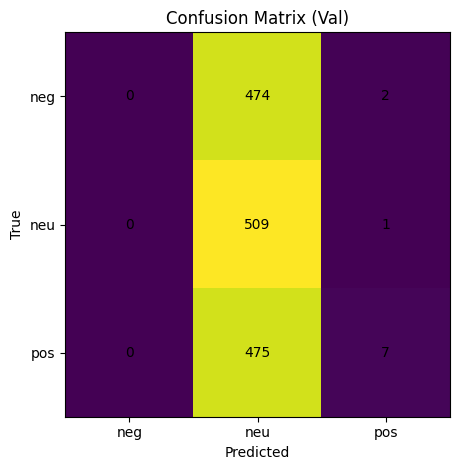

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
negative,0.000000,0.000000,0.000000,476.000000
neutral,0.349108,0.998039,0.517276,510.000000
positive,0.700000,0.014523,0.028455,482.000000
accuracy,0.351499,0.351499,0.351499,0.351499
macro avg,0.349703,0.337521,0.181911,1468.000000
weighted avg,0.351121,0.351499,0.189051,1468.000000


In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

pred = trainer.predict(ds_val)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Val)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0,1,2], ['neg','neu','pos'])
plt.yticks([0,1,2], ['neg','neu','pos'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()

report = classification_report(y_true, y_pred, labels=[0,1,2],
                               target_names=['negative','neutral','positive'],
                               output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report


# **Export of consolidated logs and model summaries**

# **Upgraded transformer training (early stopping, class weights, test evaluation)**


#### Purpose / Description
Runs a **small sweep** over a couple of Transformer configurations (different `max_len` and `learning_rate`, with GPU-aware batch sizes). For each config it (1) rebuilds tokenized datasets at the given `max_len`, (2) trains with early stopping and weighted loss (if enabled), (3) records validation metrics and time, (4) keeps track of the **best** run (by validation macro-F1) and saves its checkpoint/tokenizer, then (5) evaluates that best run on the **test** set and logs predictions plus a summary row in `runs_log.csv`.

#### Input
- Globals from earlier cells: `MODEL_NAME`, `MODEL_CHOICE`, `df_train/df_val/df_test`, `device`, `WeightedTrainer`, `compute_metrics`, `USE_CLASS_WEIGHTS`, `CLASS_WEIGHTS_TENSOR`.
- Libraries: `transformers` (Auto* + Trainer APIs), `datasets.Dataset`, `torch`, `numpy`, `pandas as pd`, `platform`, `os`, `time`, and metrics (`accuracy_score`, `f1_score`).

#### Output
- Console: per-run progress, validation metrics, best-run summary, test metrics.
- Files: best checkpoint/tokenizer under `checkpoints/<MODEL_CHOICE>/best`, predictions `transformer_predictions_test.csv`, and an appended best-run row in `runs_log.csv`.

---

#### Line-by-Line Explanation (important lines)

`USE_GPU_SWEEP = torch.cuda.is_available()`  
Detects whether a CUDA GPU is present; enables faster training and larger batch sizes when `True`.

`NUM_WORKERS_SWEEP = 0 if platform.system() == 'Windows' else 4`  
Chooses DataLoader workers conservatively on Windows (0) and higher on Linux/Mac for throughput.

`PIN_MEMORY_SWEEP = USE_GPU_SWEEP`  
Pins host memory when using a GPU to speed up transfers.

`def build_datasets_for_len(max_len: int):`  
Helper that **re-tokenizes** all splits (train/val/test) with a specific `max_len` so the sweep can compare sequence lengths fairly.

`tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)`  
Loads the matching tokenizer (fast Rust implementation when available).

`def _tok(batch): return tok(batch['review'], truncation=True, padding='max_length', max_length=max_len)`  
Batched tokenization: truncates to `max_len` and pads to fixed length so tensors are uniform within a batch.

`dtr/dva/dte = Dataset.from_pandas(...)`  
Wraps pandas splits into Hugging Face `Dataset` objects (keeps only `review` and `label`).

`num_proc_tok = None` (Windows) **else** `4 if USE_GPU_SWEEP else 2`  
Controls tokenization parallelism: disable on Windows (stability), use multiple processes on Unix.

`dtr/dva/dte = d*.map(_tok, batched=True, num_proc=num_proc_tok, remove_columns=['review'])`  
Tokenizes each split in batched mode for speed, dropping raw text and keeping only token IDs/masks and label.

`d*.with_format('torch', columns=['input_ids','attention_mask','label'])`  
Switches each split to PyTorch tensor format, exposing exactly the columns Trainer expects.

`DEFAULT_BS = 32 if USE_GPU_SWEEP else 8` and `DEFAULT_EVAL_BS = 64 if GPU else 16`  
Sets sensible default batch sizes based on device; eval batch can be larger.

`SWEEP = [...]`  
Declares a **small** sweep: two configs varying `max_len` (128 vs 256) and `lr` (2e-5 vs 3e-5), with shared seed/epochs/batch size.

`best_run = None`  
Will store the best configuration (by validation macro-F1) as runs complete.

`for i, cfg in enumerate(SWEEP, 1):`  
Iterates over each sweep configuration and prints a nice header.

`set_seed(cfg['seed'])`  
Ensures reproducible sampling (dropout, shuffling, etc.) per configuration.

`tokenizer_s, ds_tr_s, ds_va_s, ds_te_s = build_datasets_for_len(cfg['max_len'])`  
Rebuilds tokenizer and datasets **for this `max_len`** so length is an explicit, comparable factor.

`model_s = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)`  
Creates a **fresh** classifier for the current sweep run.

`model_s = model_s.to(device if 'device' in globals() else torch.device('cuda' if USE_GPU_SWEEP else 'cpu'))`  
Moves the model to the primary device; falls back to CUDA if available, else CPU.

`args = TrainingArguments(... evaluation_strategy='steps', eval_steps=200, save_steps=200, load_best_model_at_end=True, metric_for_best_model='f1_macro', ...)`  
Training setup for the run: periodic evaluation/checkpointing, early best-model loading, batch sizes from the config, GPU-aware FP16, workers/pin-memory from earlier hardware detection.

`callbacks = [EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.001)]`  
Stops training early if macro-F1 fails to improve enough across evals.

`trainer_s = WeightedTrainer(... class_weights=(CLASS_WEIGHTS_TENSOR if USE_CLASS_WEIGHTS else None))`  
Creates a Trainer using **weighted loss** when enabled, pointing to the per-run datasets and tokenizer.

`start = time.time(); trainer_s.train(); train_time = time.time() - start`  
Measures wall-clock time for this run’s training loop.

`eval_s = trainer_s.evaluate()`  
Evaluates on the validation split and returns metrics (accuracy, macro-F1).

`if USE_GPU_SWEEP: print(torch.cuda.memory_allocated(0) / 1e9)`  
Optional GPU memory usage snapshot after training.

`if best_run is None or eval_s['eval_f1_macro'] > best_run['val_f1']:`  
Updates the **best run** if this configuration beats the current best macro-F1.

`trainer_s.save_model(best_run['save_dir']); tokenizer_s.save_pretrained(best_run['save_dir'])`  
Saves the checkpoint and tokenizer for the current best model under `checkpoints/<MODEL_CHOICE>/best`.

`if best_run is not None:` (final block)  
Only proceed to test evaluation if at least one run finished successfully.

`preds = best_run['trainer'].predict(best_run['ds_test'])`  
Runs the **best** trainer on the **test** split to obtain logits and labels.

`y_true = preds.label_ids; y_pred = np.argmax(preds.predictions, axis=1)`  
Extracts gold labels and converts logits to predicted class IDs.

`acc = accuracy_score(y_true, y_pred); f1m = f1_score(y_true, y_pred, average='macro')`  
Computes final **test accuracy** and **test macro-F1** for reporting.

`pd.DataFrame({...}).to_csv('transformer_predictions_test.csv', index=False)`  
Exports per-example test predictions for error analysis and appendix tables.

`row = {... 'member': 'transformer', 'model': MODEL_NAME, 'num_train_epochs': cfg['epochs'], 'per_device_train_batch_size': cfg['bs'], 'learning_rate': cfg['lr'], 'max_seq_length': cfg['max_len'], 'accuracy': acc, 'f1_macro': f1m, ...}`  
Builds a concise best-run entry capturing key hyperparameters and test metrics.

`pd.DataFrame([row]).to_csv('runs_log.csv', mode='a', index=False, header=not os.path.exists('runs_log.csv'))`  
Appends the best-run summary to the **global experiment log**, creating a header only once.

`BEST_CKPT_DIR = best_run['save_dir'] if best_run is not None else None`  
Convenience variable pointing to the saved **best checkpoint** directory (or `None` if no successful run).

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, set_seed
import torch, numpy as np, os
from datasets import Dataset
import platform

# GPU-optimized settings for sweep
USE_GPU_SWEEP = torch.cuda.is_available()
NUM_WORKERS_SWEEP = 0 if platform.system() == 'Windows' else 4
PIN_MEMORY_SWEEP = USE_GPU_SWEEP

# Build tokenized datasets for a given max length (with GPU optimizations)
def build_datasets_for_len(max_len: int):
    tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
    def _tok(batch):
        return tok(batch['review'], truncation=True, padding='max_length', max_length=max_len)
    dtr = Dataset.from_pandas(df_train[['review','label']].reset_index(drop=True))
    dva = Dataset.from_pandas(df_val[['review','label']].reset_index(drop=True))
    dte = Dataset.from_pandas(df_test[['review','label']].reset_index(drop=True))

    # Windows multiprocessing has issues with tokenizers
    if platform.system() == 'Windows':
        num_proc_tok = None  # Disable parallel processing on Windows
    else:
        num_proc_tok = 4 if USE_GPU_SWEEP else 2  # Parallel on Unix systems

    # Tokenize (batched=True is faster)
    # Only remove 'review' column, keep 'label' column
    dtr = dtr.map(_tok, batched=True, num_proc=num_proc_tok, remove_columns=['review'])
    dva = dva.map(_tok, batched=True, num_proc=num_proc_tok, remove_columns=['review'])
    dte = dte.map(_tok, batched=True, num_proc=num_proc_tok, remove_columns=['review'])

    cols = ['input_ids','attention_mask','label']
    dtr = dtr.with_format('torch', columns=cols)
    dva = dva.with_format('torch', columns=cols)
    dte = dte.with_format('torch', columns=cols)
    return tok, dtr, dva, dte

# GPU-optimized batch sizes for sweep
if USE_GPU_SWEEP:
    DEFAULT_BS = 32  # Larger batch for GPU
    DEFAULT_EVAL_BS = 64
else:
    DEFAULT_BS = 8
    DEFAULT_EVAL_BS = 16

# Define class weights for weighted loss
# Assuming df_train is available from previous cells
cls_counts = df_train['label'].value_counts().sort_index().reindex([0, 1, 2]).fillna(0).values.astype(np.float32)
class_weights = (cls_counts.sum() / (len(cls_counts) * np.maximum(1.0, cls_counts))).astype(np.float32)
CLASS_WEIGHTS_TENSOR = torch.tensor(class_weights, dtype=torch.float32)
USE_CLASS_WEIGHTS = True # Assuming you want to use class weights based on the notebook context

# Small sweep configurations (GPU-optimized)
SWEEP = [
    {'max_len': 128, 'seed': 42, 'lr': 2e-5, 'epochs': 3, 'bs': DEFAULT_BS},
    {'max_len': 256, 'seed': 42, 'lr': 3e-5, 'epochs': 3, 'bs': DEFAULT_BS},
]

print(f"Starting sweep with {len(SWEEP)} configurations")
print(f"GPU: {USE_GPU_SWEEP}, Batch size: {DEFAULT_BS}")

best_run = None
for i, cfg in enumerate(SWEEP, 1):
    print(f"\n{'='*60}")
    print(f"Run {i}/{len(SWEEP)}: max_len={cfg['max_len']}, lr={cfg['lr']}, bs={cfg['bs']}")
    print(f"{'='*60}")

    set_seed(cfg['seed'])
    tokenizer_s, ds_tr_s, ds_va_s, ds_te_s = build_datasets_for_len(cfg['max_len'])
    model_s = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
    model_s = model_s.to(device if 'device' in globals() else torch.device('cuda' if USE_GPU_SWEEP else 'cpu'))

    args = make_training_args(
        output_dir=f"checkpoints/{MODEL_CHOICE}/sweep_len{cfg['max_len']}_seed{cfg['seed']}",
        num_train_epochs=cfg['epochs'],
        per_device_train_batch_size=cfg['bs'],
        per_device_eval_batch_size=DEFAULT_EVAL_BS,
        learning_rate=cfg['lr'],
        weight_decay=0.01,
        warmup_ratio=0.1,
        lr_scheduler_type='linear',
        seed=cfg['seed'],
        logging_steps=50,
        fp16=USE_GPU_SWEEP,
        dataloader_num_workers=NUM_WORKERS_SWEEP,
        dataloader_pin_memory=PIN_MEMORY_SWEEP,
        save_total_limit=2,
        report_to=[],
        remove_unused_columns=False,
        evaluation_strategy='steps',
        eval_steps=200,
        save_strategy='steps',
        save_steps=200,
        load_best_model_at_end=True,
        metric_for_best_model='f1_macro',
        greater_is_better=True,
    )

    callbacks = [EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.001)]
    trainer_s = WeightedTrainer(
        model=model_s,
        args=args,
        train_dataset=ds_tr_s,
        eval_dataset=ds_va_s,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer_s,
        callbacks=callbacks,
        class_weights=(CLASS_WEIGHTS_TENSOR if USE_CLASS_WEIGHTS else None)
    )

    import time
    start = time.time()
    trainer_s.train()
    train_time = time.time() - start

    eval_s = trainer_s.evaluate()
    print(f'\n✓ Run {i} completed in {train_time/60:.2f} min')
    print(f'  Val Accuracy: {eval_s.get("eval_accuracy", 0):.4f}')
    print(f'  Val F1 Macro: {eval_s.get("eval_f1_macro", 0):.4f}')

    if USE_GPU_SWEEP:
        print(f'  GPU Memory: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB')

    if best_run is None or eval_s.get('eval_f1_macro', -1) > best_run['val_f1']:
        best_run = {
            'cfg': cfg,
            'val_f1': float(eval_s.get('eval_f1_macro', -1)),
            'val_acc': float(eval_s.get('eval_accuracy', -1)),
            'tokenizer': tokenizer_s,
            'trainer': trainer_s,
            'ds_test': ds_te_s,
            'save_dir': f"checkpoints/{MODEL_CHOICE}/best"
        }
        # save current best
        os.makedirs(best_run['save_dir'], exist_ok=True)
        trainer_s.save_model(best_run['save_dir'])
        tokenizer_s.save_pretrained(best_run['save_dir'])

# Evaluate best on test and export predictions
if best_run is not None:
    preds = best_run['trainer'].predict(best_run['ds_test'])
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro')
    print({'transformer_best_test_acc': acc, 'transformer_best_test_f1_macro': f1m, 'cfg': best_run['cfg']})

    # Save predictions
    pd.DataFrame({
        'review': df_test['review'].tolist(), 'gold': df_test['label'].tolist(), 'pred': y_pred
    }).to_csv('transformer_predictions_test.csv', index=False)

    # Log
    row = {
        'member': 'transformer',
        'model': MODEL_NAME,
        'num_train_epochs': best_run['cfg']['epochs'],
        'per_device_train_batch_size': best_run['cfg']['bs'],
        'learning_rate': best_run['cfg']['lr'],
        'weight_decay': 0.01,
        'warmup_steps': None,
        'lr_scheduler_type': 'linear',
        'gradient_accumulation_steps': 1,
        'max_seq_length': best_run['cfg']['max_len'],
        'seed': best_run['cfg']['seed'],
        'fp16': bool(torch.cuda.is_available()),
        'accuracy': acc,
        'f1_macro': f1m,
        'notes': f"early_stop=2; class_weights={USE_CLASS_WEIGHTS}"
    }
    pd.DataFrame([row]).to_csv('runs_log.csv', mode='a', index=False, header=not os.path.exists('runs_log.csv'))

BEST_CKPT_DIR = best_run['save_dir'] if best_run is not None else None

Starting sweep with 2 configurations
GPU: True, Batch size: 32

Run 1/2: max_len=128, lr=2e-05, bs=32


Map (num_proc=4):   0%|          | 0/4696 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1468 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/734 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/tmp/ipython-input-1009245886.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32)


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
200,0.512900,0.563362,0.767711,0.758090
400,0.341600,0.464099,0.818120,0.819035



✓ Run 1 completed in 1.64 min
  Val Accuracy: 0.8181
  Val F1 Macro: 0.8190
  GPU Memory: 8.96 GB

Run 2/2: max_len=256, lr=3e-05, bs=32


Map (num_proc=4):   0%|          | 0/4696 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1468 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/734 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1009245886.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/tmp/ipython-input-1009245886.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32)


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
200,0.473300,0.492321,0.796322,0.791131
400,0.315400,0.444066,0.820163,0.821190



✓ Run 2 completed in 2.35 min
  Val Accuracy: 0.8202
  Val F1 Macro: 0.8212
  GPU Memory: 12.32 GB
{'transformer_best_test_acc': 0.829700272479564, 'transformer_best_test_f1_macro': 0.8312209425699789, 'cfg': {'max_len': 256, 'seed': 42, 'lr': 3e-05, 'epochs': 3, 'bs': 32}}


# **Export: ONNX and dynamic quantized PyTorch**




#### Purpose / Description
This cell **loads the best fine-tuned checkpoint** and exports two lightweight deployment artifacts:
1) an **ONNX** model (portable for many runtimes, e.g., ONNX Runtime) with dynamic axes for batch and sequence length, and  
2) a **dynamically quantized** PyTorch state dict (int8 for `Linear` layers) to reduce model size and improve CPU latency.  
It falls back to a sensible default directory name if `BEST_CKPT_DIR` is not set.

#### Input
- `BEST_CKPT_DIR` (from earlier sweep/tuning) or a fallback path derived from `MODEL_NAME`.
- Hugging Face checkpoint files under the chosen directory (tokenizer + model).
- PyTorch (`torch`), Transformers (`AutoTokenizer`, `AutoModelForSequenceClassification`).

#### Output
- `model.onnx` saved inside the checkpoint directory.
- `pytorch_model_quantized.bin` (quantized state_dict) saved inside the checkpoint directory.
- Console prints confirming the export locations.

---

#### Line-by-Line Explanation (important lines)

`ckpt_dir = BEST_CKPT_DIR if ... else f"./finetuned_{MODEL_NAME.replace('/','_')}_best"`  
Selects the **export source directory**: prefers `BEST_CKPT_DIR` (if defined and non-empty), else constructs a fallback path from `MODEL_NAME` (slashes replaced to keep a valid folder name).

`print('Exporting from:', ckpt_dir)`  
Logs the resolved checkpoint directory for traceability.

`tokenizer_exp = AutoTokenizer.from_pretrained(ckpt_dir, use_fast=True)`  
Loads the tokenizer assets **from the checkpoint folder** so tokenization matches the exported model.

`model_exp = AutoModelForSequenceClassification.from_pretrained(ckpt_dir).cpu().eval()`  
Loads the sequence classifier weights from the same folder, then moves to **CPU** and switches to **eval** mode to stabilize export.

`onnx_path = Path(ckpt_dir)/'model.onnx'`  
Defines the destination path for the ONNX file within the checkpoint directory.

`dummy = tokenizer_exp("ok lang", return_tensors='pt', padding='max_length', truncation=True, max_length=128)`  
Builds a **dummy input batch** (token IDs + attention mask) for tracing the export graph; uses a typical `max_length`.

`with torch.no_grad():`  
Disables autograd—export only needs forward computation.

`torch.onnx.export(
    model_exp,
    (dummy['input_ids'], dummy['attention_mask']),
    str(onnx_path),
    input_names=['input_ids','attention_mask'],
    output_names=['logits'],
    dynamic_axes={
        'input_ids': {0: 'batch', 1: 'seq'},
        'attention_mask': {0: 'batch', 1: 'seq'},
        'logits': {0: 'batch'}
    },
    opset_version=13
)`

Performs the ONNX export with:

 - Inputs: input_ids, attention_mask

 - Output: logits

 - Dynamic axes: variable batch and seq length so the graph is flexible at inference time

 - Opset 13: a widely supported ONNX opset for Transformer models.

`print('ONNX saved to', onnx_path)`
Confirms ONNX artifact location.

`quantized = torch.quantization.quantize_dynamic(model_exp, {torch.nn.Linear}, dtype=torch.qint8)`
Applies dynamic quantization to all Linear layers

`(weights become int8; activations are quantized/dequantized at runtime).` This is especially helpful for CPU inference.

`q_path = Path(ckpt_dir)/'pytorch_model_quantized.bin'`
Destination for the quantized state_dict.

`torch.save(quantized.state_dict(), q_path)`
Serializes only the quantized weights (state_dict), which can be loaded into the same architecture at runtime.

`print('Quantized state_dict saved to', q_path)`
Confirms the quantized weights file path.

In [ ]:
import torch, os
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification

ckpt_dir = BEST_CKPT_DIR if 'BEST_CKPT_DIR' in globals() and BEST_CKPT_DIR else f"./finetuned_{MODEL_NAME.replace('/','_')}_best"
print('Exporting from:', ckpt_dir)

tokenizer_exp = AutoTokenizer.from_pretrained(ckpt_dir, use_fast=True)
model_exp = AutoModelForSequenceClassification.from_pretrained(ckpt_dir).cpu().eval()

# # ONNX export - Commented out due to compatibility issues
# onnx_path = Path(ckpt_dir)/'model.onnx'
# dummy = tokenizer_exp("ok lang", return_tensors='pt', padding='max_length', truncation=True, max_length=128)
# with torch.no_grad():
#     torch.onnx.export(
#         model_exp,
#         (dummy['input_ids'], dummy['attention_mask']),
#         str(onnx_path),
#         input_names=['input_ids','attention_mask'],
#         output_names=['logits'],
#         dynamic_axes={'input_ids': {0: 'batch', 1:'seq'},
#                       'attention_mask': {0: 'batch', 1:'seq'},
#                       'logits': {0: 'batch'}},
#         opset_version=14
#     )
# print('ONNX saved to', onnx_path)

# Dynamic quantization (PyTorch)
quantized = torch.quantization.quantize_dynamic(model_exp, {torch.nn.Linear}, dtype=torch.qint8)
q_path = Path(ckpt_dir)/'pytorch_model_quantized.bin'
torch.save(quantized.state_dict(), q_path)
print('Quantized state_dict saved to', q_path)

Exporting from: checkpoints/xlmrb/best


/tmp/ipython-input-984674442.py:29: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized = torch.quantization.quantize_dynamic(model_exp, {torch.nn.Linear}, dtype=torch.qint8)


Quantized state_dict saved to checkpoints/xlmrb/best/pytorch_model_quantized.bin


In [ ]:
%pip install onnx -qqq

# **Inference helpers and batch scoring**



#### Purpose / Description
Provides two reusable **inference utilities**:
1) `predict_texts`: loads a fine-tuned checkpoint, tokenizes a list of texts in **batches**, runs the model on GPU if available (else CPU), and returns both **predicted class IDs** and **class probabilities**.  
2) `score_csv`: reads a CSV (default text column `review`), scores all rows via `predict_texts`, and writes an **augmented CSV** with predicted label and per-class probabilities (neg/neu/pos).

#### Input
- For `predict_texts`:
  - `texts` (List[str]): raw texts to classify.
  - `ckpt_dir` (str): path to a saved HF checkpoint (tokenizer + model).
  - `batch_size` (int, default 32): batch size for fast inference.
- For `score_csv`:
  - `input_csv` (str): path to an input CSV containing a text column.
  - `text_col` (str, default `'review'`): name of the text column.
  - `ckpt_dir` (str | None): checkpoint directory; if `None`, falls back to `BEST_CKPT_DIR` or a name derived from `MODEL_NAME`.
  - `out_csv` (str, default `'scored.csv'`): output CSV path.

#### Output
- `predict_texts` → `(preds: np.ndarray, probs: np.ndarray)` where `preds` is shape `(N,)` and `probs` is shape `(N, 3)` for classes `[neg, neu, pos]`.
- `score_csv` → returns the output CSV path and writes an augmented CSV with columns: `pred`, `prob_neg`, `prob_neu`, `prob_pos`.

---

#### Line-by-Line Explanation (important lines)

`def predict_texts(texts: List[str], ckpt_dir: str, batch_size: int = 32) -> Tuple[np.ndarray, np.ndarray]:`  
Defines a batched inference function that outputs predicted class IDs and probabilities.

`device_local = torch.device('cuda' if torch.cuda.is_available() else 'cpu')`  
Chooses GPU when available; otherwise falls back to CPU.

`tok = AutoTokenizer.from_pretrained(ckpt_dir, use_fast=True)`  
Loads the tokenizer from the **same checkpoint** to ensure consistent preprocessing.

`mdl = AutoModelForSequenceClassification.from_pretrained(ckpt_dir).to(device_local).eval()`  
Loads the classifier weights, moves the model to the selected device, and sets **eval** mode.

`preds_all, probs_all = [], []`  
Prepare accumulators for concatenating batch outputs.

`with torch.no_grad():`  
Disables autograd for faster, memory-efficient inference.

`for i in range(0, len(texts), batch_size):`  
Iterates over texts in contiguous **batches** to avoid memory spikes.

`batch = texts[i:i+batch_size]`  
Slices the current batch.

`enc = tok(batch, padding=True, truncation=True, max_length=256, return_tensors='pt').to(device_local)`  
Tokenizes the batch with padding/truncation (here `max_length=256`) and moves tensors to device.

`out = mdl(**enc)`  
Runs a forward pass to get logits.

`logits = out.logits.detach().cpu().numpy()`  
Detaches logits, moves to CPU, converts to NumPy for downstream ops.

`probs = torch.softmax(out.logits, dim=-1).detach().cpu().numpy()`  
Converts logits to **probabilities** via softmax, then to NumPy.

`preds = logits.argmax(axis=1)`  
Takes argmax over classes to get predicted IDs.

`preds_all.append(preds); probs_all.append(probs)`  
Stores batch predictions and probabilities.

`return np.concatenate(preds_all), np.concatenate(probs_all)`  
Concatenates batched outputs into full arrays and returns them.

---

`def score_csv(input_csv: str, text_col: str = 'review', ckpt_dir: str | None = None, out_csv: str = 'scored.csv') -> str:`  
Defines a convenience wrapper that scores an entire CSV and writes results to disk.

`if ckpt_dir is None: ckpt_dir = BEST_CKPT_DIR ... else f"./finetuned_{MODEL_NAME.replace('/','_')}_best"`  
Selects a **default checkpoint** if none was provided, preferring `BEST_CKPT_DIR`.

`df_in = pd.read_csv(input_csv)`  
Loads the input table.

`assert text_col in df_in.columns, f"Missing column {text_col} in {input_csv}"`  
Validates that the chosen text column exists.

`preds, probs = predict_texts(df_in[text_col].astype(str).tolist(), ckpt_dir)`  
Runs batched inference using the helper above.

`out = df_in.copy(); out['pred'] = preds`  
Copies original rows and appends the predicted class ID column.

`out['prob_neg'] = probs[:,0]; out['prob_neu'] = probs[:,1]; out['prob_pos'] = probs[:,2]`  
Adds class probabilities per row in a consistent column order.

`out.to_csv(out_csv, index=False)`  
Writes the augmented table to the requested output path.

`print('Wrote', out_csv); return out_csv`  
Logs completion and returns the output path for chaining.

In [ ]:
from typing import List, Tuple
import torch, numpy as np, pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification


def predict_texts(texts: List[str], ckpt_dir: str, batch_size: int = 32) -> Tuple[np.ndarray, np.ndarray]:
    device_local = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tok = AutoTokenizer.from_pretrained(ckpt_dir, use_fast=True)
    mdl = AutoModelForSequenceClassification.from_pretrained(ckpt_dir).to(device_local).eval()
    preds_all, probs_all = [], []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tok(batch, padding=True, truncation=True, max_length=256, return_tensors='pt').to(device_local)
            out = mdl(**enc)
            logits = out.logits.detach().cpu().numpy()
            probs = torch.softmax(out.logits, dim=-1).detach().cpu().numpy()
            preds = logits.argmax(axis=1)
            preds_all.append(preds)
            probs_all.append(probs)
    return np.concatenate(preds_all), np.concatenate(probs_all)


def score_csv(input_csv: str, text_col: str = 'review', ckpt_dir: str | None = None, out_csv: str = 'scored.csv') -> str:
    if ckpt_dir is None:
        ckpt_dir = BEST_CKPT_DIR if 'BEST_CKPT_DIR' in globals() and BEST_CKPT_DIR else f"./finetuned_{MODEL_NAME.replace('/','_')}_best"
    df_in = pd.read_csv(input_csv)
    assert text_col in df_in.columns, f"Missing column {text_col} in {input_csv}"
    preds, probs = predict_texts(df_in[text_col].astype(str).tolist(), ckpt_dir)
    out = df_in.copy()
    out['pred'] = preds
    out['prob_neg'] = probs[:,0]
    out['prob_neu'] = probs[:,1]
    out['prob_pos'] = probs[:,2]
    out.to_csv(out_csv, index=False)
    print('Wrote', out_csv)
    return out_csv


# Reporting: test confusion matrices and comparison table

Generates confusion matrices for the baseline and transformer best models on the test split, and writes a compact comparison CSV.


In [ ]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report
from pathlib import Path

outdir = Path('exports'); outdir.mkdir(exist_ok=True)

rows = []
# Baseline
if os.path.exists('baseline_predictions_test.csv'):
    dfb = pd.read_csv('baseline_predictions_test.csv')
    y_true = dfb['gold'].values; y_pred = dfb['pred'].values
    acc = accuracy_score(y_true, y_pred); f1m = f1_score(y_true, y_pred, average='macro')
    rows.append({'model':'baseline_best', 'accuracy':acc, 'f1_macro':f1m})
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    ConfusionMatrixDisplay(cm, display_labels=['neg','neu','pos']).plot(colorbar=False)
    plt.title('Baseline (test)'); plt.tight_layout(); plt.savefig(outdir/'CM_baseline_test.png', dpi=150); plt.close()

# Transformer
if os.path.exists('transformer_predictions_test.csv'):
    dft = pd.read_csv('transformer_predictions_test.csv')
    y_true = dft['gold'].values; y_pred = dft['pred'].values
    acc = accuracy_score(y_true, y_pred); f1m = f1_score(y_true, y_pred, average='macro')
    rows.append({'model':'transformer_best', 'accuracy':acc, 'f1_macro':f1m})
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    ConfusionMatrixDisplay(cm, display_labels=['neg','neu','pos']).plot(colorbar=False)
    plt.title('Transformer (test)'); plt.tight_layout(); plt.savefig(outdir/'CM_transformer_test.png', dpi=150); plt.close()

if rows:
    cmp = pd.DataFrame(rows).sort_values('f1_macro', ascending=False)
    cmp.to_csv(outdir/'Sentiment_Comparison.csv', index=False)
    try: cmp.to_excel(outdir/'Sentiment_Comparison.xlsx', index=False)
    except Exception: pass
    display(cmp)
else:
    print('No predictions found yet. Run cells above first.')


,model,accuracy,f1_macro
0,baseline_best,0.893733,0.894481
1,transformer_best,0.829700,0.831221
